<a id='start'></a>

## Machine learning notebook

This notebook performs data loading, outlier removal and data normalization and executes dimension reduction algorithms in particular LDA, PCA and PaCMAP. Afterwards, it performs binary classification using LDA and SVM on all features or a reduced features set (Pearson correlation). This version of the notebook has been optimized for the raw data set 7 in RawData_7.csv.

### Load required packages

In [1]:
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import HBox,VBox
import plotly.figure_factory as ff
import sys # To properly import the files !
import plotly.offline as plt_off
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import matplotlib
import numpy as np
import pandas as pd
import os
import sklearn.cluster as cluster
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.covariance import OAS

import random
from scipy import stats

from statannot import add_stat_annotation

import warnings
warnings.filterwarnings('ignore')

### Define data paths and load as dataframe

In [2]:
# Input directory
dbs=['B:\\Project - PD\\LRRK2 paper\\RawData_7.csv']

print("Input file: ", dbs[0])

# Output directory
output_path = 'B:\\Project - PD\\LRRK2 paper\\Figures\\RawData_7\\'

if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)
    
main_df_tot = pd.read_csv(dbs[0])

main_df_tot = main_df_tot[main_df_tot["tags"].str.contains("Gibco") == False]

display(main_df_tot.tags.value_counts())

ctrl_pos = "LRRK2 WT: DoD 37"
ctrl_neg = 'LRRK2 Mut: DoD 37'

ctrl_pos2 = "LRRK2 WT: DoD 50"
ctrl_neg2 = "LRRK2 Mut: DoD 50"

ctrl_neg_fit = "LRRK2 Mut: DoD 37"
ctrl_pos_fit = "LRRK2 WT: DoD 37"

order = ['LRRK2 WT: DoD 37', 'LRRK2 Mut: DoD 37',
         'LRRK2 WT: DoD 50', 'LRRK2 Mut: DoD 50',
         'SNCA WT: DoD 37', 'SNCA triplication: DoD 37',
         'SNCA WT: DoD 50', 'SNCA triplication: DoD 50'
        ]

box_pairs = [("LRRK2 WT: DoD 50", "LRRK2 Mut: DoD 50"), ('SNCA WT: DoD 50', 'SNCA triplication: DoD 50'),
             ("LRRK2 WT: DoD 50", "LRRK2 WT: DoD 37"), ("LRRK2 Mut: DoD 50", "LRRK2 Mut: DoD 37"),
             ("SNCA WT: DoD 50", "SNCA WT: DoD 37"), ("SNCA triplication: DoD 50", "SNCA triplication: DoD 37")
            ]

main_df_tot = main_df_tot.set_index(['Plate', 'Well'])

whole_df = main_df_tot.copy()

main_df_tot.head()

Input file:  B:\Project - PD\LRRK2 paper\RawData_7.csv


SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
LRRK2 Mut: DoD 50            112
LRRK2 Mut: DoD 37            112
SNCA WT: DoD 37              111
LRRK2 WT: DoD 37             110
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 50              84
Name: tags, dtype: int64

tags  \
Plate                                 Well                     
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03   LRRK2 WT: DoD 50   
                                      C03   LRRK2 WT: DoD 50   
                                      D03   LRRK2 WT: DoD 50   
                                      E03   LRRK2 WT: DoD 50   
                                      F03   LRRK2 WT: DoD 50   

                                            Cell_Correlation_MAP2_SNCA  \
Plate                                 Well                               
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03                     0.130000   
                                      C03                     0.089200   
                                      D03                     0.159363   
                                      E03                     0.242649   
                                      F03                     0.104367   

                                            Cell_Correlation_TH_SNCA  \
Plate                                 Well                             
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03                   0.016292   
                                      C03                   0.011791   
                                      D03                   0.024074   
                                      E03                   0.047765   
                                      F03                   0.016708   

                                            Cell_Correlation_VanSteelselsMeanX_TH_SNCA  \
Plate                                 Well                                               
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03                                      22.4421   
                                      C03                                      30.2672   
                                      D03                                      19.3221   
                                      E03                                      21.3481   
                                      F03                                      21.6617   

                                            Cell_Correlation_VanSteelselsMeanY_TH_SNCA  \
Plate                                 Well                                               
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03                                      19.3525   
                                      C03                                      17.7887   
                                      D03                                      21.2126   
                                      E03                                      24.5072   
                                      F03                                      20.9336   

                                            Cell_Correlation_VanSteelselsSigmaX_TH_SNCA  \
Plate                                 Well                                                
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03                                      0.881366   
                                      C03                                      0.908999   
                                      D03                                      1.153240   
                                      E03                                      2.508220   
                                      F03                                      0.877813   

                                            Cell_Correlation_VanSteelselsSigmaY_TH_SNCA  \
Plate                                 Well                                                
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV B03                                      0.792710   
                                      C03                                      0.532218   
                                      D03                                      1.234560   
                                      E03                                      2.818700   
                                      F03                                      0.848568   

                                            C

# Data pre-processing 
## (normalization, remove outliers, feature reduction)

### Defenition of functions for data pre-processing

In [3]:
def remove_outliers_by_plate(df_in, sigma, method, neg, pos):

    print('[DATA BEFORE OUTLIERS:]', len(df_in))

    list_df_plate = []

    df_in['Plate2'] = df_in.index.get_level_values('Plate')

    for plate in np.unique(df_in['Plate2']):

        df_plate = pd.DataFrame(df_in[df_in['Plate2'] == plate])

        data_neg = df_plate[df_plate['tags'] == neg]
        data_pos = df_plate[df_plate['tags'] == pos]
        data_cpd = df_plate[~((df_plate['tags'] == neg) | (df_plate['tags'] == pos))]

        print('CPDS LEN = ', len(data_cpd))

        data_neg = data_neg.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_pos = data_pos.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_cpd = data_cpd.drop(['Plate2'], axis=1, errors='ignore')

        data_neg = data_neg.astype(np.float64)
        data_pos = data_pos.astype(np.float64)

        if method == 'std':
            data_neg = data_neg[np.abs(data_neg - data_neg.mean()) / data_neg.std() <= sigma].dropna()
            data_pos = data_pos[np.abs(data_pos - data_pos.mean()) / data_pos.std() <= sigma].dropna()

        elif method == 'std_quartiles':
            # data_neg = data_neg[np.abs(data_neg - data_neg.median()) <= sigma * np.abs(data_neg.quantile(0.75) - data_neg.quantile(0.25))].dropna()
            # data_pos = data_pos[np.abs(data_pos - data_pos.median()) <= sigma * np.abs(data_pos.quantile(0.75) - data_pos.quantile(0.25))].dropna()
            data_neg = data_neg[np.abs(data_neg - data_neg.median()) <= sigma * np.abs(data_neg.mad())].dropna()
            data_pos = data_pos[np.abs(data_pos - data_pos.median()) <= sigma * np.abs(data_pos.mad())].dropna()

        data_neg['tags'] = neg
        data_pos['tags'] = pos

        df = pd.concat([data_neg, data_pos, data_cpd])
        list_df_plate.append(df)

    df_concat = pd.concat(list_df_plate)

    print('[DATA AFTER OUTLIERS:]', df_concat.shape[0])

    return df_concat

def norm_centered_by_plate(df, norm_type, neg, pos):

    df['Plate2'] = df.index.get_level_values('Plate')

    list_df_group = []

    for plate in np.unique(df['Plate2']):

        df_plate = df[df['Plate2'] == plate]

        neg_group = pd.DataFrame(df_plate[df_plate['tags'] == neg])
        pos_group = pd.DataFrame(df_plate[df_plate['tags'] == pos])

        for column in df_plate:
            if column != 'Plate2' and column != 'tags':

                mean_neg = np.mean(neg_group[column])
                mean_pos = np.mean(pos_group[column])
                median_neg = np.median(neg_group[column])
                mad_neg = neg_group[column].mad()
                # diff_quartile_neg = np.abs(np.quantile(neg_group[column], 0.75) - np.quantile(neg_group[column], 0.25)) / 2.

                std_neg = np.std(neg_group[column])
                std_pos = np.std(pos_group[column])

                min_neg = np.min(neg_group[column])
                max_neg = np.max(neg_group[column])

                min_pos = np.min(pos_group[column])
                max_pos = np.max(pos_group[column])

                min_5sigma_neg = 0.
                min_5sigma_pos = 0.
                max_5sigma_neg = 0.
                max_5sigma_pos = 0.

                if norm_type == 'std':
                    if std_neg == 0:
                        std_neg = 1.

                    print(column, median_neg, std_neg)

                    df_plate[column] = (df_plate[column] - median_neg) / std_neg

                if norm_type == 'std_quartiles':
                    if mad_neg == 0:
                        mad_neg = 1.

                    print(column, median_neg, mad_neg)

                    df_plate[column] = (df_plate[column] - median_neg) / mad_neg

                if norm_type == 'mean':
                    if mean_neg == 0:
                        mean_neg = 1
                    df_plate[column] = df_plate[column] / mean_neg

                if norm_type == 'min_max':

                    sigma = 5

                    if mean_neg < mean_pos:
                        min_5sigma_neg = mean_neg - sigma * std_neg
                        max_5sigma_pos = mean_pos + sigma * std_pos

                        if min_5sigma_neg > min_neg:
                            min_neg = min_5sigma_neg

                        if max_5sigma_pos < max_pos:
                            max_pos = max_5sigma_pos

                    if mean_pos < mean_neg:
                        min_5sigma_pos = mean_pos - sigma * std_pos
                        max_5sigma_neg = mean_neg + sigma * std_neg

                        if min_5sigma_pos > min_pos:
                            min_pos = min_5sigma_pos

                        if max_5sigma_neg < max_neg:
                            max_neg = max_5sigma_neg

                    df_plate[column] -= min_neg

                    if (max_neg - min_neg) != 0:
                        df_plate[column] /= (max_neg - min_neg)
                    else:
                        df_plate[column] /= 1.

        list_df_group.append(df_plate)

    normalized_df = pd.concat(list_df_group)
    normalized_df.drop('Plate2', axis=1, inplace=True)

    print('[DATA NORMALIZED]')

    return normalized_df

In [4]:
def dim_reduction_LDA(main_df_tot, list_features, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, feat_name):

    # df_reducted = main_df_tot[list_features]

    main_df_tot = main_df_tot.reset_index()

    print(main_df_tot.Plate.value_counts())

    df_37days = main_df_tot[main_df_tot.Plate.str.contains("63")]
    df_50days = main_df_tot[main_df_tot.Plate.str.contains("61")]

    print("Length DoD 37 input: ", len(df_37days))
    print("Length DoD 50 input: ", len(df_50days))

    df_37days = df_37days.set_index(['Plate', 'Well'])
    df_50days = df_50days.set_index(['Plate', 'Well'])
    
    df_37days = df_37days[list_features]
    df_50days = df_50days[list_features]

    main_df_wo_outliers_37_days = remove_outliers_by_plate(df_37days, 5, 'std_quartiles', ctrl_neg, ctrl_pos)
    df_normed_reducted_37days = norm_centered_by_plate_filtered(df_37days, main_df_wo_outliers_37_days, 'std_quartiles', ctrl_neg, ctrl_pos)

    main_df_wo_outliers_50_days = remove_outliers_by_plate(df_50days, 5, 'std_quartiles', ctrl_neg2, ctrl_pos2)
    df_normed_reducted_50days = norm_centered_by_plate_filtered(df_50days, main_df_wo_outliers_50_days, 'std_quartiles', ctrl_neg2, ctrl_pos2)

    df_normed_reducted = pd.concat([df_normed_reducted_37days, df_normed_reducted_50days])
    df_normed_reducted_ctrls = df_normed_reducted[df_normed_reducted.tags.isin([ctrl_neg_fit, ctrl_pos_fit])]
    
    ### LDA :

    list_tags_ctrl_reducted = df_normed_reducted_ctrls['tags']
    list_tags_reducted = df_normed_reducted['tags']

    ##

    le = preprocessing.LabelEncoder()
    le.fit(list_tags_ctrl_reducted)
    labels = le.transform(list_tags_ctrl_reducted)
    X = df_normed_reducted_ctrls[list_features[:-1]]

    lda = LDA()
    lda.fit(X=X, y=labels)
    lda_transform = lda.transform(df_normed_reducted[list_features[:-1]])

    ##

    data1 = lda_transform[list_tags_reducted==ctrl_neg_fit]
    data2 = lda_transform[list_tags_reducted==ctrl_pos_fit]

    plt.hist(data1, color='blue', bins=50)
    plt.hist(data2, color='green', bins=50)
    plt.show()

    print(lda_transform)
    df_normed_reducted = df_normed_reducted.reset_index()

    df_lda = pd.DataFrame()
    df_lda['tags'] = df_normed_reducted['tags']
    df_lda[feat_name] = lda_transform[:,0]
    df_lda['Plate'] = df_normed_reducted['Plate']
    df_lda['Well'] = df_normed_reducted['Well']

    df_lda = df_lda.set_index(['Plate', 'Well'])

    return df_lda

def cross_valid_z_prime(model, X, labels, iter_nb, train_set_proportion):

    list_z_train = []
    list_z_test = []

    # skf = StratifiedKFold(n_splits=5, shuffle=True)
    # skf.get_n_splits(X, labels)

    sss = StratifiedShuffleSplit(n_splits=iter_nb, test_size=1.0-train_set_proportion, random_state=0)
    sss.get_n_splits(X, labels)
    
    X = np.array(X)
    labels = np.array(labels)
    
    # for train_index, test_index in skf.split(X, labels):
    for train_index, test_index in sss.split(X, labels):

        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

    # for i in range(iter_nb):
    #     x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels, random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.transform(x_train[y_train == 0])
        x_pos_train = model.transform(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.transform(x_test[y_test == 0])
        x_pos_test = model.transform(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def cross_valid_z_prime_svm(model, X, labels, iter_nb, train_set_proportion, output_path):

    list_z_train = []
    list_z_test = []

    sss = StratifiedShuffleSplit(n_splits=iter_nb, test_size=1.0-train_set_proportion, random_state=0)
    sss.get_n_splits(X, labels)
    
    X = np.array(X)
    labels = np.array(labels)
    
    # for train_index, test_index in skf.split(X, labels):
    for train_index, test_index in sss.split(X, labels):

        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

    # for i in range(iter_nb):
    #     x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
    #                                                         random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.predict_proba(x_train[y_train == 0])[:,0]
        x_pos_train = model.predict_proba(x_train[y_train == 1])[:,0]

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.predict_proba(x_test[y_test == 0])[:,0]
        x_pos_test = model.predict_proba(x_test[y_test == 1])[:,0]

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def cross_valid_z_prime_linear_svm(model, X, labels, iter_nb, train_set_proportion, output_path):

    list_z_train = []
    list_z_test = []

    sss = StratifiedShuffleSplit(n_splits=iter_nb, test_size=1.0-train_set_proportion, random_state=0)
    sss.get_n_splits(X, labels)
    
    X = np.array(X)
    labels = np.array(labels)
    
    # for train_index, test_index in skf.split(X, labels):
    for train_index, test_index in sss.split(X, labels):

        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

    # for i in range(iter_nb):
    #     x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
    #                                                         random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.decision_function(x_train[y_train == 0])
        x_pos_train = model.decision_function(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.decision_function(x_test[y_test == 0])
        x_pos_test = model.decision_function(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def norm_centered_by_plate_filtered(df, df_filtered, norm_type, neg, pos):

    df['Plate2'] = df.index.get_level_values('Plate')
    df_filtered['Plate2'] = df_filtered.index.get_level_values('Plate')

    print(df['tags'].unique())
    print(df['Plate2'].unique())

    list_df_group = []

    for plate in np.unique(df['Plate2']):
        df_plate = df[df['Plate2'] == plate]

        df_plate_filtered = df_filtered[df_filtered.Plate2==plate]

        WT_group = pd.DataFrame(df_plate_filtered[df_plate_filtered['tags'] == neg])
        GS_group = pd.DataFrame(df_plate_filtered[df_plate_filtered['tags'] == pos])

        print(WT_group)
        print(WT_group.describe())

        for column in df_plate:
            if column != 'Plate2' and column != 'tags':

                mean_wt = np.mean(WT_group[column])
                mean_gs = np.mean(GS_group[column])
                median_wt = np.median(WT_group[column])
                diff_quartile_wt = np.abs(np.quantile(WT_group[column], 0.75) - np.quantile(WT_group[column], 0.25))
                mad_wt = WT_group[column].mad()

                std_wt = np.std(WT_group[column])
                std_gs = np.std(GS_group[column])

                min_wt = np.min(WT_group[column])
                max_wt = np.max(WT_group[column])

                min_gs = np.min(GS_group[column])
                max_gs = np.max(GS_group[column])

                min_5sigma_wt = 0.
                min_5sigma_gs = 0.
                max_5sigma_wt = 0.
                max_5sigma_gs = 0.

                if norm_type == 'std':
                    if std_wt == 0:
                        std_wt = 1.

                    print(column, mean_wt, std_wt)

                    df_plate[column] = (df_plate[column] - median_wt) / std_wt

                if norm_type == 'std_quartiles':
                    if mad_wt == 0:
                        mad_wt = 1.

                    print(column, median_wt, mad_wt)

                    df_plate[column] = (df_plate[column] - median_wt) / mad_wt

                if norm_type == 'mean':
                    if mean_wt == 0:
                        mean_wt = 1
                    df_plate[column] = df_plate[column] / mean_wt

                if norm_type == 'min_max':

                    sigma = 5

                    if mean_wt < mean_gs:
                        min_5sigma_wt = mean_wt - sigma * std_wt
                        max_5sigma_gs = mean_gs + sigma * std_gs

                        if min_5sigma_wt > min_wt:
                            min_wt = min_5sigma_wt

                        if max_5sigma_gs < max_gs:
                            max_gs = max_5sigma_gs

                    if mean_gs < mean_wt:
                        min_5sigma_gs = mean_gs - sigma * std_gs
                        max_5sigma_wt = mean_wt + sigma * std_wt

                        if min_5sigma_gs > min_gs:
                            min_gs = min_5sigma_gs

                        if max_5sigma_wt < max_wt:
                            max_wt = max_5sigma_wt

                    df_plate[column] -= min_wt

                    if (max_wt - min_wt) != 0:
                        df_plate[column] /= (max_wt - min_wt)
                    else:
                        df_plate[column] /= 1.

        list_df_group.append(df_plate)

    normalized_df = pd.concat(list_df_group)
    normalized_df.drop('Plate2', axis=1, inplace=True)

    print('[DATA NORMALIZED]')

    return normalized_df

### Feature Reduction

SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
LRRK2 Mut: DoD 50            112
LRRK2 Mut: DoD 37            112
SNCA WT: DoD 37              111
LRRK2 WT: DoD 37             110
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 50              84
Name: tags, dtype: int64

Index(['tags', 'Cell_Correlation_MAP2_SNCA', 'Cell_Correlation_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanX_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanY_TH_SNCA',
       'Cell_Correlation_VanSteelselsSigmaX_TH_SNCA',
       'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA',
       'Cell_Intensity_MeanIntensity_MAP2',
       'Cell_Intensity_MeanIntensity_SNCA', 'Cell_Intensity_MeanIntensity_TH',
       ...
       'Nuclei_Number_Dead', 'Nuclei_Number_Living', 'Nuclei_Number_MAP2',
       'Nuclei_Number_MAP2_SNCA', 'Nuclei_Number_SNCA', 'Nuclei_Number_TH',
       'Nuclei_Number_TH_SNCA', 'Nuclei_Ratio_Dead', 'Nuclei_Ratio_Living',
       'Nuclei_Surface_MeanArea'],
      dtype='object', length=127)
SNCA-Mat61-x40-d50-map2-snca-th-p1-AV      252
SNCA-Mat61-x40-d50-map2-snca-th-p2.2-AV    252
SNCA-Mat63-x40-map2-snca-th-p1-AV          224
SNCA-Mat63-x40-map2-snca-th-p2-AV          207
Name: Plate, dtype: int64
Length DoD 37 input:  431
Length DoD 50 input:  504
[DATA BEFORE OUTL

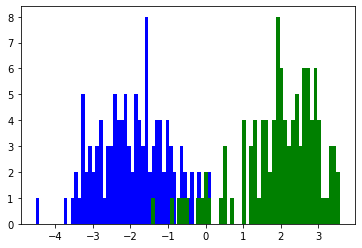

[[ 3.41358350e+00]
 [ 2.16824245e+00]
 [ 3.05011888e+00]
 [ 2.10439430e+00]
 [ 3.38142598e+00]
 [ 2.51027409e+00]
 [ 2.05166657e+00]
 [ 2.60890962e+00]
 [ 1.84985490e+00]
 [ 2.75057841e+00]
 [ 2.30875761e+00]
 [ 2.94163531e+00]
 [ 2.89189316e+00]
 [ 2.03781004e+00]
 [ 2.31764441e+00]
 [ 2.92201487e+00]
 [ 3.43367730e+00]
 [ 2.06675722e+00]
 [ 2.68504357e+00]
 [ 1.86337624e+00]
 [ 3.31475461e+00]
 [ 1.61044179e+00]
 [ 1.16938450e+00]
 [ 3.44772649e+00]
 [ 1.78863048e+00]
 [ 2.54492158e+00]
 [ 2.26931157e+00]
 [ 2.90550653e+00]
 [ 7.09276245e-01]
 [ 1.87613519e+00]
 [ 1.74140260e+00]
 [ 3.06583954e+00]
 [ 2.58762077e+00]
 [ 1.95691113e+00]
 [ 3.58508660e+00]
 [ 2.38406577e+00]
 [ 3.27736629e+00]
 [ 2.29316659e+00]
 [ 1.47082258e+00]
 [ 3.58663872e+00]
 [ 2.73958391e+00]
 [ 2.62753433e+00]
 [ 1.34529453e+00]
 [ 2.85174143e+00]
 [ 2.65308340e+00]
 [ 2.30048382e+00]
 [ 1.87657795e+00]
 [ 3.03549631e+00]
 [ 2.85710638e+00]
 [ 2.97883605e+00]
 [ 1.75591984e+00]
 [ 1.49444121e+00]
 [ 3.3476619

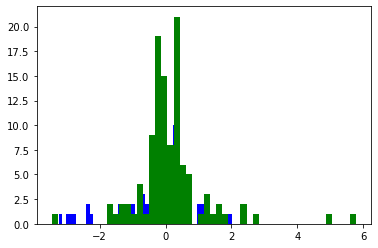

[[-4.25009114e-01]
 [-1.27121856e-02]
 [ 4.71425880e-01]
 [-1.60074614e+00]
 [ 6.24894122e-01]
 [ 1.30446654e+00]
 [ 4.08447128e-01]
 [ 3.88753259e-01]
 [ 3.63289999e-01]
 [ 3.39868470e-01]
 [ 1.17579555e-01]
 [ 1.19475452e+00]
 [ 2.86680327e-01]
 [ 1.71928157e+00]
 [-1.85450507e-01]
 [ 4.48971819e-01]
 [ 1.60723398e+00]
 [ 2.62860672e-02]
 [-7.84139421e-01]
 [-8.61727765e-01]
 [ 3.86280837e-01]
 [ 3.33658267e-01]
 [ 7.62197708e-01]
 [-2.36712511e-01]
 [ 2.42835153e-01]
 [-2.86871663e-01]
 [ 4.75037129e-01]
 [ 1.22721892e+00]
 [ 6.06422451e-02]
 [ 3.80282611e-01]
 [ 5.34993925e-01]
 [ 2.35909858e+00]
 [ 3.65284751e-01]
 [-1.05248974e+00]
 [-2.50603462e-01]
 [ 2.36025667e+00]
 [ 2.54104008e-01]
 [-1.03057315e+00]
 [-2.96326245e-01]
 [-2.24805568e-01]
 [ 3.65779912e-01]
 [ 2.92572639e-01]
 [ 4.10743532e-02]
 [ 4.64935451e-02]
 [ 6.50115669e-02]
 [-5.29372833e-01]
 [ 4.23530625e-01]
 [-3.43761428e-01]
 [ 8.20778090e-02]
 [ 3.72109562e-01]
 [ 3.21381596e-01]
 [ 6.97098390e-01]
 [ 7.5574854

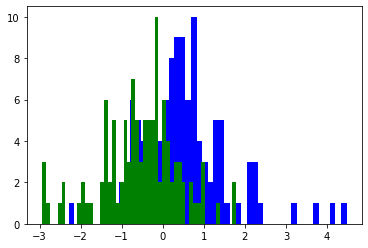

[[-1.71174240e+00]
 [-7.21622781e-01]
 [ 8.80207124e-01]
 [-2.38780892e+00]
 [-9.68516128e-01]
 [-7.35208385e-01]
 [-2.40344137e-01]
 [-9.06809593e-01]
 [-8.71771210e-02]
 [-2.76237089e+00]
 [ 3.46363764e-02]
 [-2.47970962e-01]
 [-1.50764818e-01]
 [ 3.99935989e-01]
 [-2.39321204e+00]
 [-1.96308090e+00]
 [-1.33882458e+00]
 [ 2.03468901e-01]
 [-4.60289098e-01]
 [ 9.35839119e-01]
 [-3.06314447e-01]
 [ 7.11122844e-01]
 [-4.80196762e-01]
 [-1.91797452e-01]
 [-7.15371661e-01]
 [-1.81199839e-01]
 [-1.39301828e-01]
 [ 1.32491083e+00]
 [-1.41358442e+00]
 [-1.81446148e+00]
 [-7.67653124e-01]
 [ 9.43832549e-02]
 [-7.00227440e-01]
 [-1.26445000e+00]
 [-1.93549204e+00]
 [ 1.46844862e-01]
 [-1.33612062e-01]
 [-7.01813207e-01]
 [ 7.74833350e-01]
 [-8.24993944e-01]
 [-2.62826768e-01]
 [ 3.52992319e-01]
 [-2.93586710e+00]
 [-1.36119791e+00]
 [-2.87855662e+00]
 [-7.32262449e-01]
 [-1.48232084e+00]
 [-1.07306110e+00]
 [-3.13650994e-01]
 [ 5.63310690e-02]
 [-2.42116515e-01]
 [-4.31580323e-01]
 [-5.1604239

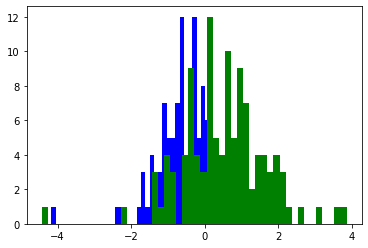

[[ 1.38931093e+00]
 [ 3.68618915e-01]
 [ 9.40576979e-01]
 [ 3.29031377e-01]
 [ 1.53327879e+00]
 [ 1.26371528e+00]
 [-1.35319612e+00]
 [ 6.48520638e-01]
 [ 6.27481342e-01]
 [ 3.85427547e+00]
 [ 1.93937681e+00]
 [ 1.88189702e+00]
 [ 9.72137946e-01]
 [ 8.22754145e-01]
 [-3.21139830e-02]
 [ 1.14427146e+00]
 [ 1.88293456e-01]
 [-3.23940185e-01]
 [ 1.91264996e-01]
 [ 1.01700321e+00]
 [ 1.09944351e+00]
 [ 2.10498938e+00]
 [ 6.16055286e-01]
 [ 1.30139428e+00]
 [ 1.10129509e-01]
 [ 1.74069200e+00]
 [ 4.30113854e-01]
 [ 5.37540497e-01]
 [-4.43969662e-01]
 [-1.09571706e+00]
 [-1.44319334e-01]
 [-2.02414425e-01]
 [ 1.80824053e-01]
 [-3.94931669e-01]
 [-6.04830487e-01]
 [-4.90588886e-01]
 [ 1.00440866e+00]
 [ 9.47821268e-01]
 [-2.02268281e-01]
 [ 1.04776741e+00]
 [ 4.67621853e-01]
 [ 3.55356607e+00]
 [ 1.62388618e-01]
 [-4.12502892e-01]
 [-4.34788608e-01]
 [-9.30673382e-01]
 [-9.98884379e-01]
 [ 2.11012698e-01]
 [-5.23152529e-02]
 [-3.57460549e-01]
 [-1.03248125e+00]
 [ 5.60105740e-01]
 [ 9.6944224

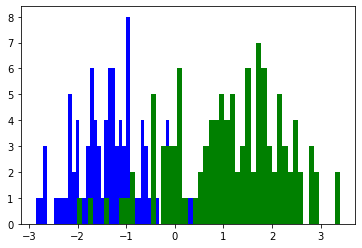

[[ 4.95352658e-01]
 [ 2.93088904e+00]
 [ 2.84069512e+00]
 [ 2.27326084e+00]
 [ 2.53670510e+00]
 [ 2.14209954e+00]
 [ 1.15218539e+00]
 [ 1.59043462e+00]
 [ 1.75506034e+00]
 [ 1.10650665e+00]
 [ 7.41272317e-01]
 [ 1.92405008e+00]
 [ 7.90992638e-01]
 [ 3.34046587e+00]
 [ 6.66805785e-01]
 [ 1.37728445e+00]
 [ 2.52229086e+00]
 [ 1.94256671e+00]
 [ 9.52216051e-01]
 [ 2.32550764e+00]
 [ 9.66647175e-02]
 [ 1.53320606e+00]
 [ 9.58579865e-01]
 [ 2.45480095e+00]
 [ 1.09112964e+00]
 [ 2.43715848e+00]
 [ 1.91472495e+00]
 [ 3.40050951e+00]
 [-1.37793315e+00]
 [ 2.14133075e+00]
 [ 1.50867542e+00]
 [ 2.13707521e+00]
 [ 1.22460846e+00]
 [ 1.29500007e+00]
 [ 2.10684332e+00]
 [ 9.86666645e-01]
 [ 1.68281678e+00]
 [ 2.84102978e+00]
 [ 8.23481257e-01]
 [ 1.67459562e+00]
 [ 1.40418060e+00]
 [ 1.79799286e+00]
 [ 1.30960185e-01]
 [ 2.18708979e+00]
 [ 1.30004265e+00]
 [ 1.81975467e+00]
 [ 2.31396247e+00]
 [ 1.19610073e+00]
 [ 2.37727350e+00]
 [ 1.83802984e+00]
 [ 6.42630117e-02]
 [ 1.87683031e+00]
 [ 1.8742738

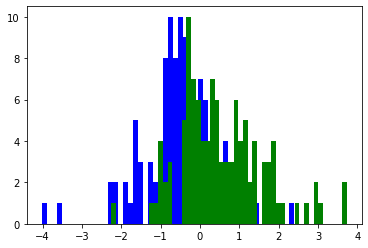

[[ 3.04316453e+00]
 [ 1.60069295e+00]
 [ 1.64214895e+00]
 [ 3.85984531e-01]
 [ 5.00315672e-01]
 [-3.26795654e-01]
 [ 3.10730020e-01]
 [-2.37417654e-01]
 [ 3.82812282e-01]
 [-1.13103668e+00]
 [-1.65564654e-01]
 [ 8.64180455e-02]
 [-2.12431178e-01]
 [-3.31683513e-01]
 [ 3.70727456e+00]
 [ 1.41710204e+00]
 [ 2.01851698e+00]
 [ 2.43992427e-01]
 [ 7.79290842e-01]
 [ 6.01480071e-01]
 [-1.10929473e-01]
 [ 6.27407878e-02]
 [-1.11297721e-01]
 [ 7.36690165e-02]
 [ 1.43637127e-01]
 [-7.94952630e-01]
 [-1.82936206e-01]
 [-4.39153448e-01]
 [ 2.91240076e+00]
 [ 1.91015058e+00]
 [ 1.82204492e+00]
 [ 9.91267752e-01]
 [ 1.19227314e+00]
 [ 6.55001023e-01]
 [-1.04936862e+00]
 [ 6.00480220e-02]
 [-1.81536440e-01]
 [-7.61894119e-02]
 [-2.30251460e-01]
 [-3.60856074e-01]
 [-1.01384861e+00]
 [-3.39078599e-01]
 [ 3.72473132e+00]
 [ 1.83762147e+00]
 [ 2.93064615e+00]
 [ 1.77944308e+00]
 [ 4.66658758e-01]
 [ 1.42171250e-01]
 [-4.36576541e-02]
 [ 2.78083181e-01]
 [ 2.09128028e-01]
 [-3.44200409e-01]
 [-8.5194234

SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
LRRK2 Mut: DoD 50            112
LRRK2 Mut: DoD 37            112
SNCA WT: DoD 37              111
LRRK2 WT: DoD 37             110
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 50              84
Name: tags, dtype: int64

In [5]:
features_textures = ["Cell_Texture_SNCA_AngularSecondMoment_000",
                    "Cell_Texture_SNCA_AngularSecondMoment_045",
                    "Cell_Texture_SNCA_AngularSecondMoment_090",
                    "Cell_Texture_SNCA_AngularSecondMoment_135",
                    "Cell_Texture_SNCA_Contrast_000",
                    "Cell_Texture_SNCA_Contrast_045",
                    "Cell_Texture_SNCA_Contrast_090",
                    "Cell_Texture_SNCA_Contrast_135",
                    "Cell_Texture_SNCA_Correlation_000",
                    "Cell_Texture_SNCA_Correlation_045",
                    "Cell_Texture_SNCA_Correlation_090",
                    "Cell_Texture_SNCA_Correlation_135",
                    "Cell_Texture_SNCA_DifferenceEntropy_000",
                    "Cell_Texture_SNCA_DifferenceEntropy_045",
                    "Cell_Texture_SNCA_DifferenceEntropy_090",
                    "Cell_Texture_SNCA_DifferenceEntropy_135",
                    "Cell_Texture_SNCA_DifferenceVariance_000",
                    "Cell_Texture_SNCA_DifferenceVariance_045",
                    "Cell_Texture_SNCA_DifferenceVariance_090",
                    "Cell_Texture_SNCA_DifferenceVariance_135",
                    "Cell_Texture_SNCA_Entropy_000",
                    "Cell_Texture_SNCA_Entropy_045",
                    "Cell_Texture_SNCA_Entropy_090",
                    "Cell_Texture_SNCA_Entropy_135",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_000",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_045",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_090",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr1_135",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_000",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_045",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_090",
                    "Cell_Texture_SNCA_InfoMeasuresOfCorr2_135",
                    "Cell_Texture_SNCA_InverseDiffMoment_000",
                    "Cell_Texture_SNCA_InverseDiffMoment_045",
                    "Cell_Texture_SNCA_InverseDiffMoment_090",
                    "Cell_Texture_SNCA_InverseDiffMoment_135",
                    "Cell_Texture_SNCA_SumAverage_000",
                    "Cell_Texture_SNCA_SumAverage_045",
                    "Cell_Texture_SNCA_SumAverage_090",
                    "Cell_Texture_SNCA_SumAverage_135",
                    "Cell_Texture_SNCA_SumEntropy_000",
                    "Cell_Texture_SNCA_SumEntropy_045",
                    "Cell_Texture_SNCA_SumEntropy_090",
                    "Cell_Texture_SNCA_SumEntropy_135",
                    "Cell_Texture_SNCA_SumOfSquares_000",
                    "Cell_Texture_SNCA_SumOfSquares_045",
                    "Cell_Texture_SNCA_SumOfSquares_090",
                    "Cell_Texture_SNCA_SumOfSquares_135",
                    "Cell_Texture_SNCA_SumVariance_000",
                    "Cell_Texture_SNCA_SumVariance_045",
                    "Cell_Texture_SNCA_SumVariance_090",
                    "Cell_Texture_SNCA_SumVariance_135",
                    "tags"]                        

features_correlations = ["Cell_Correlation_MAP2_SNCA",
                        "Cell_Correlation_TH_SNCA",
                        "Cell_Correlation_VanSteelselsMeanX_TH_SNCA",
                        "Cell_Correlation_VanSteelselsMeanY_TH_SNCA",
                        "Cell_Correlation_VanSteelselsSigmaX_TH_SNCA",
                        "Cell_Correlation_VanSteelselsSigmaY_TH_SNCA",
                        'tags']


features_individual_cell = ["IndividualCell_Intensity_MeanIntensity_SNCA",
                            "IndividualCell_Intensity_RadialProfile_InterceptFit_SNCA",
                            "IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Maximum_SNCA",
                            "IndividualCell_Intensity_RadialProfile_MeanCoeffVar_SNCA",
                            "IndividualCell_Intensity_RadialProfile_MeanGradient_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Mean_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Median_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Minimum_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Q1_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Q3_SNCA",
                            "IndividualCell_Intensity_RadialProfile_SlopeFit_SNCA",
                            "IndividualCell_Intensity_RadialProfile_StdCoeffVar_SNCA",
                            "IndividualCell_Intensity_RadialProfile_Std_SNCA",
                            "IndividualCell_Intensity_SumIntensity_SNCA",
                            "IndividualCell_Surface_MeanSurface_SNCA",
                            "tags"]

features_membranes = ["Membrane_Intensity_MeanIntensity_MAP2",
                    "Membrane_Intensity_MeanIntensity_SNCA",
                    "Membrane_Intensity_MeanIntensity_TH",
                    "Membrane_Surface_SurfacePerNuclei_MAP2",
                    "Membrane_Surface_SurfacePerNuclei_SNCA",
                    "Membrane_Surface_SurfacePerNuclei_TH",
                    "tags"]


feature_ratio_nuclei = ["Nuclei_Living_Ratio_MAP2",
                        "Nuclei_Living_Ratio_MAP2_SNCA",
                        "Nuclei_Living_Ratio_SNCA",
                        "Nuclei_Living_Ratio_TH",
                        "Nuclei_Living_Ratio_TH_SNCA",
                        "tags"]

feature_cytoplasm = ["Cytoplasm_Intensity_MeanIntensity_SNCA",
                    "Cytoplasm_MAP2_SNCA_Intensity_MeanIntensity_SNCA",
                    "Cytoplasm_SurfacePerNuclei_SNCA",
                    "Cytoplasm_SurfacePerNuclei_TH_SNCA",
                    "tags"]

display(main_df_tot.tags.value_counts())
print(main_df_tot.columns)

df_lda_transform_texture = dim_reduction_LDA(main_df_tot, features_textures, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, 'Texture_Features')
df_lda_transform_correlations = dim_reduction_LDA(main_df_tot, features_correlations, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, 'Correlations_Features')
df_lda_transform_individual_cell = dim_reduction_LDA(main_df_tot, features_individual_cell, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, 'Individual_Cell_Features')
df_lda_transform_membranes = dim_reduction_LDA(main_df_tot, features_membranes, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, 'Membranes_Features')
df_lda_transform_ratio_nuclei = dim_reduction_LDA(main_df_tot, feature_ratio_nuclei, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, 'Ratio_Nuclei_Features')
df_lda_transform_cytoplasm = dim_reduction_LDA(main_df_tot, feature_cytoplasm, ctrl_neg, ctrl_pos, ctrl_neg2, ctrl_pos2, 'Cytoplasm_Features')

main_df_tot['Texture_Features'] = df_lda_transform_texture['Texture_Features']
main_df_tot['Correlations_Features'] = df_lda_transform_correlations['Correlations_Features']
main_df_tot['Individual_Cell_Features'] = df_lda_transform_individual_cell['Individual_Cell_Features']
main_df_tot['Membranes_Features'] = df_lda_transform_membranes['Membranes_Features']
main_df_tot['Ratio_Nuclei_Features'] = df_lda_transform_ratio_nuclei['Ratio_Nuclei_Features']
main_df_tot['Cytoplasm_Features'] = df_lda_transform_cytoplasm['Cytoplasm_Features']

display(main_df_tot.tags.value_counts())

### Definition of parameters for outlier removal

In [6]:
selected_features = [#"Cell_Intensity_MeanIntensity_MAP2",
                    "Cell_Intensity_MeanIntensity_SNCA",
                    #"Cell_Intensity_MeanIntensity_TH",
                    "Cell_Intensity_SumIntensityPerNuclei_SNCA",
                    "Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA",
                    "Cell_Neurites_BranchingPointsPerNuclei_MAP2",
                    "Cell_Neurites_BranchingPointsPerNuclei_TH",
                    "Cell_Neurites_LengthPerNuclei_MAP2",
                    "Cell_Neurites_LengthPerNuclei_TH",
                    "Cell_SurfacePerNuclei_MAP2",
                    "Cell_SurfacePerNuclei_MAP2_SNCA",
                    "Cell_SurfacePerNuclei_SNCA",
                    "Cell_SurfacePerNuclei_TH",
                    "Cell_SurfacePerNuclei_TH_SNCA",
                    "Cell_Surface_RatioSurface_TH_SNCA",
                    "Cell_TH_SNCA_Intensity_MeanIntensity_SNCA",
                    "Cell_TH_SNCA_Intensity_MeanIntensity_TH",
                    "Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA",
                    'Texture_Features',
                    'Correlations_Features',
                    'Individual_Cell_Features',
                    'Membranes_Features',
                    'Ratio_Nuclei_Features',
                    'Cytoplasm_Features',
                    #"Nuclei_Ratio_Dead",
                    #"Nuclei_Ratio_Living",
                    #"Nuclei_Surface_MeanArea",
                    "tags"]

method_outliers  = 'std' # 'std', 'std_quartiles'
outliers_sigma = 3

main_df = main_df_tot[selected_features]

### Outlier removal and normalization

In [7]:
display(main_df.tags.value_counts())

main_df_wo_outliers = pd.DataFrame()

main_df = main_df.reset_index()
main_df_37 = main_df[main_df.Plate.str.contains('63')]
main_df_50 = main_df[main_df.Plate.str.contains('61')]

main_df_37 = main_df_37.set_index(['Plate', 'Well'])
main_df_50 = main_df_50.set_index(['Plate', 'Well'])

if method_outliers == 'std':
    main_df_wo_outliers_37 = remove_outliers_by_plate(main_df_37, outliers_sigma, 'std', ctrl_neg, ctrl_pos)
    main_df_normed_37 = norm_centered_by_plate(main_df_wo_outliers_37, 'std', ctrl_neg, ctrl_pos)

    main_df_wo_outliers_50 = remove_outliers_by_plate(main_df_50, outliers_sigma, 'std', ctrl_neg2, ctrl_pos2)
    main_df_normed_50 = norm_centered_by_plate(main_df_wo_outliers_50, 'std', ctrl_neg2, ctrl_pos2)
else:
    main_df_wo_outliers_37 = remove_outliers_by_plate(main_df_37, outliers_sigma, 'std_quartiles', ctrl_neg, ctrl_pos)
    main_df_normed_37 = norm_centered_by_plate(main_df_wo_outliers_37, 'std_quartiles', ctrl_neg, ctrl_pos)

    main_df_wo_outliers_50 = remove_outliers_by_plate(main_df_50, outliers_sigma, 'std_quartiles', ctrl_neg2, ctrl_pos2)
    main_df_normed_50 = norm_centered_by_plate(main_df_wo_outliers_50, 'std_quartiles', ctrl_neg2, ctrl_pos2)

main_df = pd.concat([main_df_normed_37, main_df_normed_50])

X_all_cpds = main_df[selected_features[:-1]]
Y_all_cpds = main_df['tags']

display(main_df.tags.value_counts())

df = main_df[main_df.tags.isin([ctrl_neg_fit, ctrl_pos_fit])]
X = df[selected_features[:-1]]
Y = df['tags']

whole_x = main_df[selected_features[:-1]]
whole_y = main_df['tags']

SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
LRRK2 Mut: DoD 50            112
LRRK2 Mut: DoD 37            112
SNCA WT: DoD 37              111
LRRK2 WT: DoD 37             110
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 50              84
Name: tags, dtype: int64

[DATA BEFORE OUTLIERS:] 431
CPDS LEN =  112
CPDS LEN =  97
[DATA AFTER OUTLIERS:] 401
Cell_Intensity_MeanIntensity_SNCA 380.356 51.96918167876686
Cell_Intensity_SumIntensityPerNuclei_SNCA 1501520.0 360611.64390772465
Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA 385.65049999999997 56.42707273853434
Cell_Neurites_BranchingPointsPerNuclei_MAP2 10.548850000000002 1.158297585762467
Cell_Neurites_BranchingPointsPerNuclei_TH 7.73454 0.6483216213790237
Cell_Neurites_LengthPerNuclei_MAP2 744.6485 50.53142758547782
Cell_Neurites_LengthPerNuclei_TH 654.9655 54.95461405861747
Cell_SurfacePerNuclei_MAP2 16660.9 784.1033533486763
Cell_SurfacePerNuclei_MAP2_SNCA 4112.9400000000005 668.0658906313059
Cell_SurfacePerNuclei_SNCA 3737.1400000000003 861.2132191307537
Cell_SurfacePerNuclei_TH 13269.599999999999 749.4150293005159
Cell_SurfacePerNuclei_TH_SNCA 5047.76 606.5811258448506
Cell_Surface_RatioSurface_TH_SNCA 0.954646 0.17455836714196887
Cell_TH_SNCA_Intensity_MeanIntensity_SNCA 414.64750000000004 10

SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
SNCA WT: DoD 37              111
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 37              97
LRRK2 Mut: DoD 50             97
LRRK2 Mut: DoD 37             95
LRRK2 WT: DoD 50              71
Name: tags, dtype: int64

### Inspect individual feature distributions

In [8]:
df_ctrls = main_df[main_df.tags.isin([ctrl_neg_fit, ctrl_pos_fit])]

df_ctrls_neg = df_ctrls[df_ctrls.tags==ctrl_neg_fit]
df_ctrls_pos = df_ctrls[df_ctrls.tags==ctrl_pos_fit]

for col in df_ctrls.columns:
    
    if col != 'tags':

        fig = px.histogram(df_ctrls, x=col, color="tags", title=col, nbins=100)
        fig.show() 

        feat_zfactor = 1 - 3*(df_ctrls_neg[col].std()+df_ctrls_pos[col].std()) / np.abs(df_ctrls_neg[col].mean()-df_ctrls_pos[col].mean())

        print('ZFactor', col, feat_zfactor)      

ZFactor Cell_Intensity_MeanIntensity_SNCA -63.05870053058156


ZFactor Cell_Intensity_SumIntensityPerNuclei_SNCA -12.109588930889862


ZFactor Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA -24.766986216680753


ZFactor Cell_Neurites_BranchingPointsPerNuclei_MAP2 -3.4268439389653125


ZFactor Cell_Neurites_BranchingPointsPerNuclei_TH -3.019106917072256


ZFactor Cell_Neurites_LengthPerNuclei_MAP2 -8.583979301754011


ZFactor Cell_Neurites_LengthPerNuclei_TH -3.330813720131543


ZFactor Cell_SurfacePerNuclei_MAP2 -1.707006035029916


ZFactor Cell_SurfacePerNuclei_MAP2_SNCA -8.002593006282346


ZFactor Cell_SurfacePerNuclei_SNCA -9.930597400928688


ZFactor Cell_SurfacePerNuclei_TH -1.6609792194605202


ZFactor Cell_SurfacePerNuclei_TH_SNCA -5.37567674883283


ZFactor Cell_Surface_RatioSurface_TH_SNCA -10.675407595786812


ZFactor Cell_TH_SNCA_Intensity_MeanIntensity_SNCA -34.26373419372572


ZFactor Cell_TH_SNCA_Intensity_MeanIntensity_TH -83.19229386034947


ZFactor Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA -8.108804948271068


ZFactor Texture_Features -0.8319244985262231


ZFactor Correlations_Features -41.40868847841946


ZFactor Individual_Cell_Features -4.590934462912679


ZFactor Membranes_Features -4.088084194567313


ZFactor Ratio_Nuclei_Features -1.523535455732394


ZFactor Cytoplasm_Features -4.487597904185887


### LDA classifier reduced feature set
Regularized Classification of the data using LDA


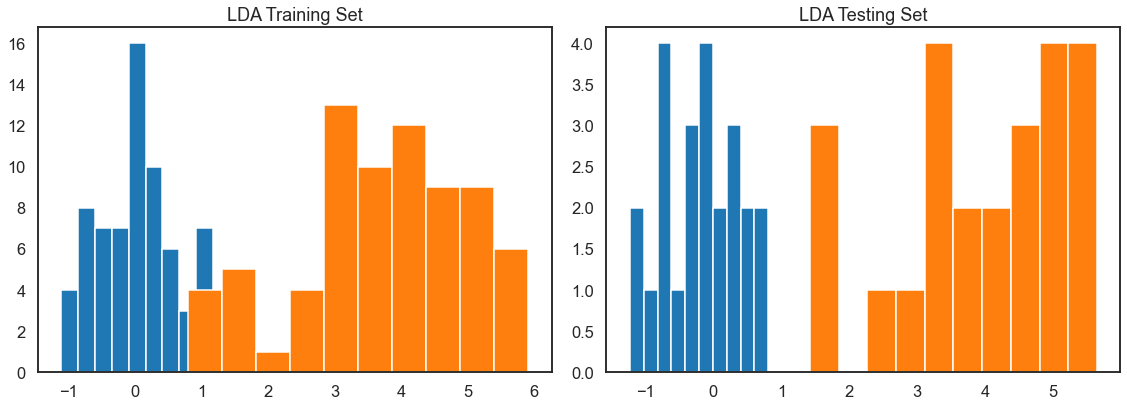

Cross valid Accuracy: 0.93 (+/- 0.16)




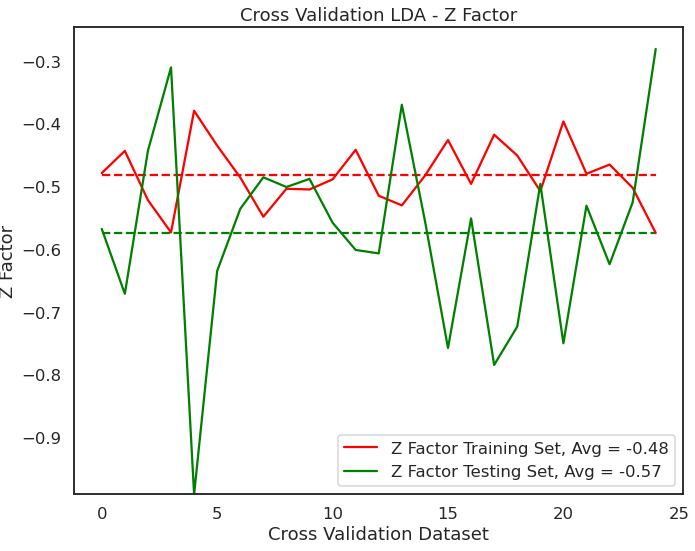

In [9]:
output_path_all = output_path+'/all_set2/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

train_set_proportion = 0.75
shrink = 'auto'

le = LabelEncoder() 
Y = le.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)
lda_analysis.fit(x_train, y_train)

LDA_train = lda_analysis.transform(x_train)
LDA_test = lda_analysis.transform(x_test)

df_training_set = pd.DataFrame()

with sns.axes_style("white"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(LDA_train[y_train==0], label=ctrl_neg_fit)
	axes[0].hist(LDA_train[y_train==1], label=ctrl_pos_fit)
	axes[0].set_title('LDA Training Set')
	axes[1].hist(LDA_test[y_test==0], label=ctrl_neg_fit)
	axes[1].hist(LDA_test[y_test==1], label=ctrl_pos_fit)
	axes[1].set_title('LDA Testing Set')
	plt.tight_layout()
	plt.savefig(output_path_all+'LDA_training_test_set_shrinkage_'+str(shrink)+'_all_set.jpg')
	plt.show()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda_analysis, X, Y, cv=10)
print("Cross valid Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print('\n')

list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X, Y, 25, train_set_proportion)

with sns.axes_style("white"), sns.plotting_context("talk"):
	fig, ax = plt.subplots(figsize=(10,8))
	plt.plot(range(len(list_z_train)), list_z_train, color='red', label='Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train))
	plt.plot(range(len(list_z_test)), list_z_test, color='green', label='Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test))
	plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors='red', linestyles='dashed')
	plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors='green', linestyles='dashed')
	plt.title('Cross Validation LDA - Z Factor')
	plt.ylabel('Z Factor')
	plt.xlabel('Cross Validation Dataset')
	plt.legend()
	min = np.min(np.concatenate([list_z_train, list_z_test]))
	min = np.min([0, min])
	plt.ylim(bottom=min)
	plt.tight_layout()


### LDA Projection

Mapping of addtional classes to binary classification space of two reference classes.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LRRK2 WT: DoD 50 v.s. LRRK2 Mut: DoD 50: Welch's t-test independent samples, P_val=1.806e-08 stat=-6.125e+00
SNCA WT: DoD 50 v.s. SNCA triplication: DoD 50: Welch's t-test independent samples, P_val=8.124e-04 stat=-3.403e+00
LRRK2 WT: DoD 37 v.s. LRRK2 WT: DoD 50: Welch's t-test independent samples, P_val=2.158e-43 stat=2.133e+01
LRRK2 Mut: DoD 37 v.s. LRRK2 Mut: DoD 50: Welch's t-test independent samples, P_val=9.063e-01 stat=-1.179e-01
SNCA WT: DoD 37 v.s. SNCA WT: DoD 50: Welch's t-test independent samples, P_val=3.232e-36 stat=1.530e+01
SNCA triplication: DoD 37 v.s. SNCA triplication: DoD 50: Welch's t-test independent samples, P_val=6.023e-15 stat=8.941e+00


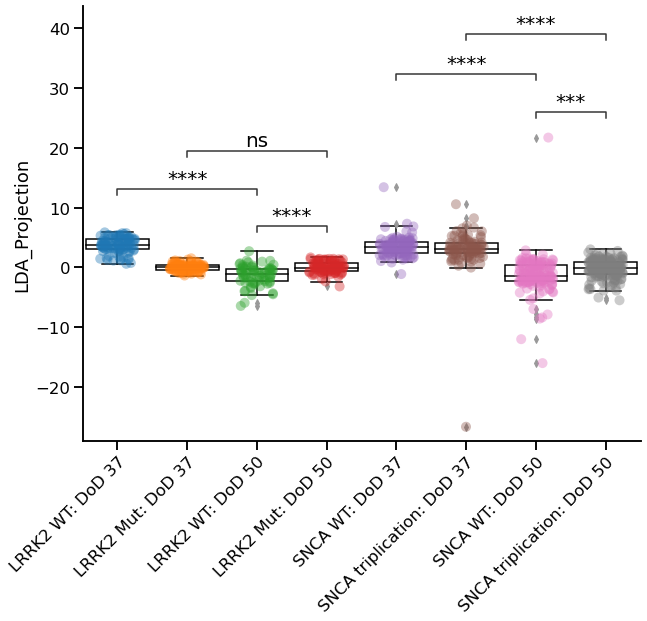

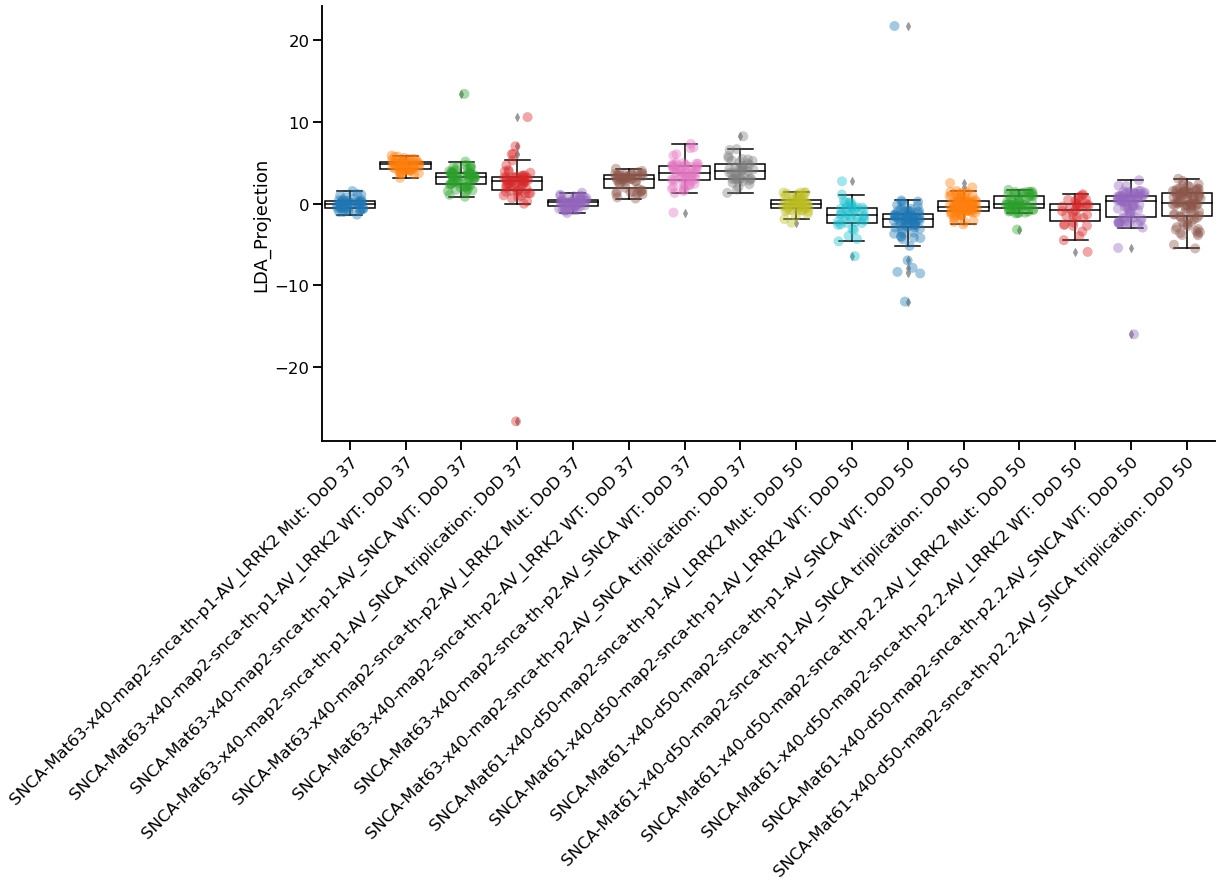

In [10]:
LDA_dmso_and_cpds = lda_analysis.transform(X_all_cpds)

X_all_cpds_lda = X_all_cpds.copy()

X_all_cpds_lda['LDA_Projection'] = LDA_dmso_and_cpds[:,0]
X_all_cpds_lda['tags'] = Y_all_cpds

X_all_cpds_pl_well = X_all_cpds.reset_index()
plates = X_all_cpds_pl_well['Plate']

list_tags_plates = []
for i in range(len(Y_all_cpds)):
    list_tags_plates.append(plates[i]+'_'+Y_all_cpds[i])
    
X_all_cpds_lda['tags_plate'] = list_tags_plates

#### Rescale the graph :
# X_all_cpds_lda = X_all_cpds_lda[X_all_cpds_lda.LDA_Projection<=15]

################################
#### Principal Graph  :
################################

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10,8))
    for i, comb in enumerate(Y_all_cpds.unique()):
        if 'DMSO' in comb:
            plt.hlines(np.median(X_all_cpds_lda[Y_all_cpds==comb]['LDA_Projection']), 0, len(Y_all_cpds.unique()), colors='black', linestyle='dashed', label=Y_all_cpds.unique()[i])
    s = sns.boxplot(x="tags", y='LDA_Projection', data=X_all_cpds_lda, color='white', linewidth=1.5, width=0.9, order=order)
    s = sns.stripplot(x='tags', y='LDA_Projection', data=X_all_cpds_lda, alpha=0.4, jitter=0.25, size=10, order=order)

    for i, box in enumerate(s.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
        for j in range(6 * i, 6 * (i + 1)):
            s.lines[j].set_color('black')

    # plt.ylim(bottom=y_bottom, top=y_top)

    add_stat_annotation(s, data=X_all_cpds_lda, x='tags', y='LDA_Projection', box_pairs=box_pairs,
                loc='inside', verbose=1, test='t-test_welch', comparisons_correction=None,
                perform_stat_test=True, order=order,
                color='0.2', linewidth=1.5,
                fontsize=20)

    ax.set(xlabel=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")
    # plt.legend()
    # plt.title('LDA Projection vs Cell Line')
    plt.savefig(output_path_all+"LDA_Projection_All_Conditions_all_set_shrinkage_"+str(shrink)+".jpg")
    sns.despine()
    plt.show()

################################
#### Principal Graph by Plate  :
################################

pl_nb = len(np.unique(plates))
tag_nb = len(X_all_cpds_lda['tags_plate'].unique())

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(16,8))
    for i, comb in enumerate(X_all_cpds_lda['tags_plate'].unique()):
        if 'DMSO' in comb:
            plt.hlines(np.median(X_all_cpds_lda[X_all_cpds_lda['tags_plate']==comb]['LDA_Projection']), np.floor(i/(tag_nb/pl_nb))*(tag_nb/pl_nb), (1+np.floor(i/(tag_nb/pl_nb)))*(tag_nb/pl_nb), colors=matplotlib.cm.tab10(i%10), linestyle='dashed', label=X_all_cpds_lda['tags_plate'].unique()[i])

    s = sns.boxplot(x="tags_plate", y='LDA_Projection', data=X_all_cpds_lda, color='white', linewidth=1.5, width=0.9)
    s = sns.stripplot(x='tags_plate', y='LDA_Projection', data=X_all_cpds_lda, palette='tab10', alpha=0.4, jitter=0.25, size=10)
    for i, box in enumerate(s.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
        for j in range(6 * i, 6 * (i + 1)):
            s.lines[j].set_color('black')

    # plt.ylim(bottom=y_bottom, top=y_top)
    ax.set(xlabel=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
    #         fancybox=True, ncol=1)
    # plt.title('LDA Projection vs Cell Line')
    plt.savefig(output_path_all+"LDA_Projection_All_Conditions_all_set_shrinkage_"+str(shrink)+"_by_plate.jpg")
    sns.despine()
    plt.show()

### PCA

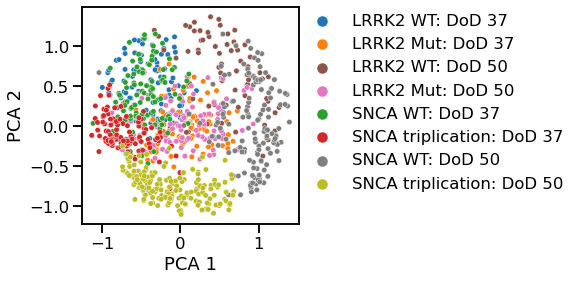

In [11]:
output_path_PCA = output_path+'PCA_Results\\'
if not os.path.exists(output_path_PCA):
	os.makedirs(output_path_PCA, exist_ok=True)

X_emb = X_all_cpds
Y_emb = Y_all_cpds

l_emb = []
l_y = []

for ord in order:
    x_emb_current = X_emb[Y_emb==ord]
    l_emb.append(x_emb_current)

    y_emb_current = Y_all_cpds.values[Y_emb==ord]
    #print(y_emb_current)
    l_y.append(y_emb_current)

X_emb = pd.concat(l_emb)
Y_emb = np.concatenate(l_y)

#print(np.unique(Y_emb))

lencoder = LabelEncoder() 
Y_emb2 = lencoder.fit_transform(Y_emb)

#print(np.unique(Y_emb))
#print(plt.get_cmap('tab10')(np.unique(Y_emb2)))

# PCA
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=2, kernel='sigmoid') ## ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’
X_kernal_pca = transformer.fit_transform(X_emb)

# Create dataframe of PCA output for plotting
X_transformed_PCA_df = pd.DataFrame(X_kernal_pca, columns=['X', 'Y'])
condition = Y_emb
X_transformed_PCA_df['Condition'] = condition

# Visualize the PCA
ax = sns.set_context("talk")
palette ={'LRRK2 WT: DoD 37': "C0", 'LRRK2 Mut: DoD 37': "C1", 
          'SNCA WT: DoD 37': "C2", 'SNCA triplication: DoD 37': "C3",
          'Ctrl Gibco: DoD 37': 'C04',
          'LRRK2 WT: DoD 50': 'C05', 'LRRK2 Mut: DoD 50': 'C06',
          'SNCA WT: DoD 50': 'C07', 'SNCA triplication: DoD 50': 'C08'
         }
ax = sns.scatterplot(data=X_transformed_PCA_df, x='X', y='Y', hue='Condition', s=30,
                    palette=palette) 
ax.set(xlabel='PCA 1')
ax.set(ylabel='PCA 2')
ax.set_box_aspect(1)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., frameon=False)
plt.savefig(output_path_PCA+"PCA.pdf", bbox_inches='tight')
plt.show()

### Embedding: PaCMAP

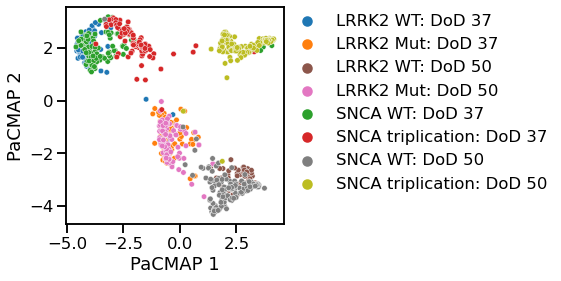

In [12]:
import pacmap

output_path_PaCMAP = output_path+'PaCMAP_Results\\'
if not os.path.exists(output_path_PaCMAP):
	os.makedirs(output_path_PaCMAP, exist_ok=True)

# PaCMAP    
embedding = pacmap.PaCMAP(n_neighbors=25, MN_ratio=0.25, FP_ratio=0.5, num_iters=5000)
X_emb2 = np.array(X_emb).reshape(X_emb.shape[0], -1)
X_transformed = embedding.fit_transform(X_emb2, init="pca")

# Create dataframe of PCA output for plotting
X_transformed_df = pd.DataFrame(X_transformed, columns=['X', 'Y'])
condition = Y_emb
X_transformed_df['Condition'] = condition

# Visualize the embedding
ax = sns.set_context("talk")
palette ={'LRRK2 WT: DoD 37': "C0", 'LRRK2 Mut: DoD 37': "C1", 
          'SNCA WT: DoD 37': "C2", 'SNCA triplication: DoD 37': "C3",
          'Ctrl Gibco: DoD 37': 'C04',
          'LRRK2 WT: DoD 50': 'C05', 'LRRK2 Mut: DoD 50': 'C06',
          'SNCA WT: DoD 50': 'C07', 'SNCA triplication: DoD 50': 'C08'
         }
ax = sns.scatterplot(data=X_transformed_df, x='X', y='Y', hue='Condition', s=30,
                    palette=palette)
ax.set(xlabel='PaCMAP 1')
ax.set(ylabel='PaCMAP 2')
ax.set_box_aspect(1)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., frameon=False)
plt.savefig(output_path_PaCMAP+"PaCMAP_selected_settings.pdf", bbox_inches='tight')
plt.show()

### Screen for suitable PaCMAP visualization settings

In [13]:
# import pacmap

# neighbors = [5, 10, 25]
# mn = [0.25, 0.5, 0.75]
# fp = [0.5, 1.0, 2.0, 4.0]

# nb = len(neighbors)*len(mn)*len(fp)

# fig, axes = plt.subplots(nb//3+1, 3, figsize=(28,120))

# counter = 0

# for neighbor in neighbors:
#     for m in mn:
#         for f in fp:

#             # initializing the pacmap instance
#             # Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
#             embedding = pacmap.PaCMAP(n_neighbors=neighbor, MN_ratio=m, FP_ratio=f, num_iters=5000)

#             # fit the data (The index of transformed data corresponds to the index of the original data)
#             X_emb2 = np.array(X_emb).reshape(X_emb.shape[0], -1)
#             X_transformed = embedding.fit_transform(X_emb2, init="pca")

#             print(np.unique(Y_emb))

#             # visualize the embedding
#             sc = axes[counter//3, counter%3].scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="tab10", c=Y_emb2, s=50)
#             legend = axes[counter//3, counter%3].legend(handles=(sc.legend_elements())[0],
#                                 loc="best", title="Classes", labels=np.unique(Y_emb).tolist())
#             axes[counter//3, counter%3].add_artist(legend)
#             axes[counter//3, counter%3].set_title('Neighbors = '+str(neighbor)+ " MN_Ratio = "+str(m)+" FP_Ratio = "+str(f)) # 'PacMAP Embedding'+

#             counter += 1
# plt.show()

### Data pre-processing (outlier removal & normalization)
All input image features and statisitical thresholds for outlier removal and normalization are listed. Some image features could not be calculated or were deemed irrelevant and where excluded (commented out).

In [14]:
# All image features to be used
selected_features = ['Cell_Correlation_MAP2_SNCA', 
            'Cell_Correlation_TH_SNCA', 
            'Cell_Correlation_VanSteelselsMeanX_TH_SNCA', 
            'Cell_Correlation_VanSteelselsMeanY_TH_SNCA', 
            'Cell_Correlation_VanSteelselsSigmaX_TH_SNCA', 
            'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA', 
            'Cell_Intensity_MeanIntensity_MAP2', 
            'Cell_Intensity_MeanIntensity_SNCA', 
            'Cell_Intensity_MeanIntensity_TH', 
            'Cell_Intensity_SumIntensityPerNuclei_SNCA', 
            'Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cell_Neurites_BranchingPointsPerNuclei_MAP2', 
            'Cell_Neurites_BranchingPointsPerNuclei_TH', 
            'Cell_Neurites_LengthPerNuclei_MAP2', 
            'Cell_Neurites_LengthPerNuclei_TH', 
            'Cell_Neurites_Length_MAP2', 
            'Cell_Neurites_Length_TH',
            'Cell_SurfacePerNuclei_MAP2', 
            'Cell_SurfacePerNuclei_MAP2_SNCA', 
            'Cell_SurfacePerNuclei_SNCA', 
            'Cell_SurfacePerNuclei_TH', 
            'Cell_SurfacePerNuclei_TH_SNCA', 
            'Cell_Surface_RatioSurface_TH_SNCA', 
            'Cell_Surface_TotalSurface_MAP2', #
            'Cell_Surface_TotalSurface_SNCA', #
            'Cell_Surface_TotalSurface_SNCA_MAP2',# 
            'Cell_Surface_TotalSurface_TH', #
            'Cell_Surface_TotalSurface_TH_SNCA',#
            'Cell_TH_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cell_TH_SNCA_Intensity_MeanIntensity_TH', 
            'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', 
            'Cell_Texture_SNCA_AngularSecondMoment_000', 
            'Cell_Texture_SNCA_AngularSecondMoment_045', 
            'Cell_Texture_SNCA_AngularSecondMoment_090', 
            'Cell_Texture_SNCA_AngularSecondMoment_135', 
            'Cell_Texture_SNCA_Contrast_000', 
            'Cell_Texture_SNCA_Contrast_045', 
            'Cell_Texture_SNCA_Contrast_090', 
            'Cell_Texture_SNCA_Contrast_135', 
            'Cell_Texture_SNCA_Correlation_000', 
            'Cell_Texture_SNCA_Correlation_045', 
            'Cell_Texture_SNCA_Correlation_090', 
            'Cell_Texture_SNCA_Correlation_135', 
            'Cell_Texture_SNCA_DifferenceEntropy_000', 
            'Cell_Texture_SNCA_DifferenceEntropy_045', 
            'Cell_Texture_SNCA_DifferenceEntropy_090', 
            'Cell_Texture_SNCA_DifferenceEntropy_135', 
            'Cell_Texture_SNCA_DifferenceVariance_000', 
            'Cell_Texture_SNCA_DifferenceVariance_045', 
            'Cell_Texture_SNCA_DifferenceVariance_090', 
            'Cell_Texture_SNCA_DifferenceVariance_135', 
            'Cell_Texture_SNCA_Entropy_000', 
            'Cell_Texture_SNCA_Entropy_045', 
            'Cell_Texture_SNCA_Entropy_090', 
            'Cell_Texture_SNCA_Entropy_135', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_000', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_045', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_090', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_135', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_000', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_045', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_090', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_135', 
            'Cell_Texture_SNCA_InverseDiffMoment_000', 
            'Cell_Texture_SNCA_InverseDiffMoment_045', 
            'Cell_Texture_SNCA_InverseDiffMoment_090', 
            'Cell_Texture_SNCA_InverseDiffMoment_135', 
            'Cell_Texture_SNCA_SumAverage_000', 
            'Cell_Texture_SNCA_SumAverage_045', 
            'Cell_Texture_SNCA_SumAverage_090', 
            'Cell_Texture_SNCA_SumAverage_135', 
            'Cell_Texture_SNCA_SumEntropy_000', 
            'Cell_Texture_SNCA_SumEntropy_045', 
            'Cell_Texture_SNCA_SumEntropy_090', 
            'Cell_Texture_SNCA_SumEntropy_135', 
            'Cell_Texture_SNCA_SumOfSquares_000', 
            'Cell_Texture_SNCA_SumOfSquares_045', 
            'Cell_Texture_SNCA_SumOfSquares_090', 
            'Cell_Texture_SNCA_SumOfSquares_135', 
            'Cell_Texture_SNCA_SumVariance_000', 
            'Cell_Texture_SNCA_SumVariance_045', 
            'Cell_Texture_SNCA_SumVariance_090', 
            'Cell_Texture_SNCA_SumVariance_135', 
            'Cytoplasm_Intensity_MeanIntensity_SNCA', 
            'Cytoplasm_MAP2_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cytoplasm_SurfacePerNuclei_SNCA', 
            'Cytoplasm_SurfacePerNuclei_TH_SNCA', 
            'Cytoplasm_Surface_TotalSurface_SNCA', 
            'IndividualCell_Intensity_MeanIntensity_SNCA', 
            'IndividualCell_Intensity_RadialProfile_InterceptFit_SNCA',
            'IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Maximum_SNCA', 
            'IndividualCell_Intensity_RadialProfile_MeanCoeffVar_SNCA', 
            'IndividualCell_Intensity_RadialProfile_MeanGradient_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Mean_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Median_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Minimum_SNCA', #
            'IndividualCell_Intensity_RadialProfile_Q1_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Q3_SNCA', 
            'IndividualCell_Intensity_RadialProfile_SlopeFit_SNCA', 
            'IndividualCell_Intensity_RadialProfile_StdCoeffVar_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Std_SNCA', 
            'IndividualCell_Intensity_SumIntensity_SNCA', 
            'IndividualCell_Surface_MeanSurface_SNCA', 
            'Membrane_Intensity_MeanIntensity_MAP2', 
            'Membrane_Intensity_MeanIntensity_SNCA', 
            'Membrane_Intensity_MeanIntensity_TH', 
            'Membrane_Surface_SurfacePerNuclei_MAP2', 
            'Membrane_Surface_SurfacePerNuclei_SNCA', 
            'Membrane_Surface_SurfacePerNuclei_TH', 
            'Nuclei_Living_Ratio_MAP2', 
            'Nuclei_Living_Ratio_MAP2_SNCA', 
            'Nuclei_Living_Ratio_SNCA', 
            'Nuclei_Living_Ratio_TH_SNCA', 
            'Nuclei_Number_Dead', 
            'Nuclei_Number_Living', 
            'Nuclei_Number_MAP2', 
            'Nuclei_Number_MAP2_SNCA', 
            'Nuclei_Number_SNCA', 
            'Nuclei_Number_TH', 
            'Nuclei_Number_TH_SNCA', 
            'Nuclei_Ratio_Dead', 
            'Nuclei_Ratio_Living', 
            'Nuclei_Surface_MeanArea',
            "tags"]

method_outliers  = 'std' # Outlier method: 'std' or 'std_quartiles'
outliers_sigma = 4 # Number of sigmas used for outlier removal

main_df = main_df_tot[selected_features]

display(main_df.tags.value_counts())

main_df_wo_outliers = pd.DataFrame()

main_df = main_df.reset_index()
main_df_37 = main_df[main_df.Plate.str.contains('63')]
main_df_50 = main_df[main_df.Plate.str.contains('61')]

main_df_37 = main_df_37.set_index(['Plate', 'Well'])
main_df_50 = main_df_50.set_index(['Plate', 'Well'])

if method_outliers == 'std':
    main_df_wo_outliers_37 = remove_outliers_by_plate(main_df_37, outliers_sigma, 'std', ctrl_neg, ctrl_pos)
    main_df_normed_37 = norm_centered_by_plate(main_df_wo_outliers_37, 'std', ctrl_neg, ctrl_pos)

    main_df_wo_outliers_50 = remove_outliers_by_plate(main_df_50, outliers_sigma, 'std', ctrl_neg2, ctrl_pos2)
    main_df_normed_50 = norm_centered_by_plate(main_df_wo_outliers_50, 'std', ctrl_neg2, ctrl_pos2)
else:
    main_df_wo_outliers_37 = remove_outliers_by_plate(main_df_37, outliers_sigma, 'std_quartiles', ctrl_neg, ctrl_pos)
    main_df_normed_37 = norm_centered_by_plate(main_df_wo_outliers_37, 'std_quartiles', ctrl_neg, ctrl_pos)

    main_df_wo_outliers_50 = remove_outliers_by_plate(main_df_50, outliers_sigma, 'std_quartiles', ctrl_neg2, ctrl_pos2)
    main_df_normed_50 = norm_centered_by_plate(main_df_wo_outliers_50, 'std_quartiles', ctrl_neg2, ctrl_pos2)

main_df = pd.concat([main_df_normed_37, main_df_normed_50])

X_all_cpds = main_df[selected_features[:-1]]
Y_all_cpds = main_df['tags']

display(main_df.tags.value_counts())

df = main_df[main_df.tags.isin([ctrl_neg_fit, ctrl_pos_fit])]
X = df[selected_features[:-1]]
Y = df['tags']

whole_x = main_df[selected_features[:-1]]
whole_y = main_df['tags']

SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
LRRK2 Mut: DoD 50            112
LRRK2 Mut: DoD 37            112
SNCA WT: DoD 37              111
LRRK2 WT: DoD 37             110
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 50              84
Name: tags, dtype: int64

[DATA BEFORE OUTLIERS:] 431
CPDS LEN =  112
CPDS LEN =  97
[DATA AFTER OUTLIERS:] 405
Cell_Correlation_MAP2_SNCA 0.0736396 0.07288224686553492
Cell_Correlation_TH_SNCA 0.0237114 0.02539131919382868
Cell_Correlation_VanSteelselsMeanX_TH_SNCA 22.6704 3.804226854890215
Cell_Correlation_VanSteelselsMeanY_TH_SNCA 22.0733 3.886371721898066
Cell_Correlation_VanSteelselsSigmaX_TH_SNCA 1.33512 1.8526414403234106
Cell_Correlation_VanSteelselsSigmaY_TH_SNCA 1.28039 1.7906055479007634
Cell_Intensity_MeanIntensity_MAP2 707.908 60.124009214404865
Cell_Intensity_MeanIntensity_SNCA 383.106 52.88978905131263
Cell_Intensity_MeanIntensity_TH 280.768 35.00828838407369
Cell_Intensity_SumIntensityPerNuclei_SNCA 1532990.0 387044.5641878448
Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA 388.018 58.71572516751976
Cell_Neurites_BranchingPointsPerNuclei_MAP2 10.7479 1.135224797966038
Cell_Neurites_BranchingPointsPerNuclei_TH 7.75448 0.6105642161283107
Cell_Neurites_LengthPerNuclei_MAP2 745.682 49.627802415927825
Ce

SNCA triplication: DoD 50    168
SNCA WT: DoD 50              140
SNCA WT: DoD 37              111
LRRK2 Mut: DoD 50            102
LRRK2 Mut: DoD 37             99
SNCA triplication: DoD 37     98
LRRK2 WT: DoD 37              97
LRRK2 WT: DoD 50              37
Name: tags, dtype: int64

### Define Cross Validation with Z Factor as score for Classification Methods :

Computes the Z Factors in function of N different shuffled training/testing sets


In [15]:
def cross_valid_z_prime(model, X, labels, iter_nb, train_set_proportion):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)
        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.transform(x_train[y_train == 0])
        x_pos_train = model.transform(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.transform(x_test[y_test == 0])
        x_pos_test = model.transform(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def cross_valid_z_prime_svm(model, X, labels, iter_nb, train_set_proportion, output_path):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.predict_proba(x_train[y_train == 0])[:,0]
        x_pos_train = model.predict_proba(x_train[y_train == 1])[:,0]

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.predict_proba(x_test[y_test == 0])[:,0]
        x_pos_test = model.predict_proba(x_test[y_test == 1])[:,0]

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def cross_valid_z_prime_linear_svm(model, X, labels, iter_nb, train_set_proportion, output_path):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.decision_function(x_train[y_train == 0])
        x_pos_train = model.decision_function(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.decision_function(x_test[y_test == 0])
        x_pos_test = model.decision_function(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

### LDA classifier with all image features¶

Regularized Classification of the data using LDA

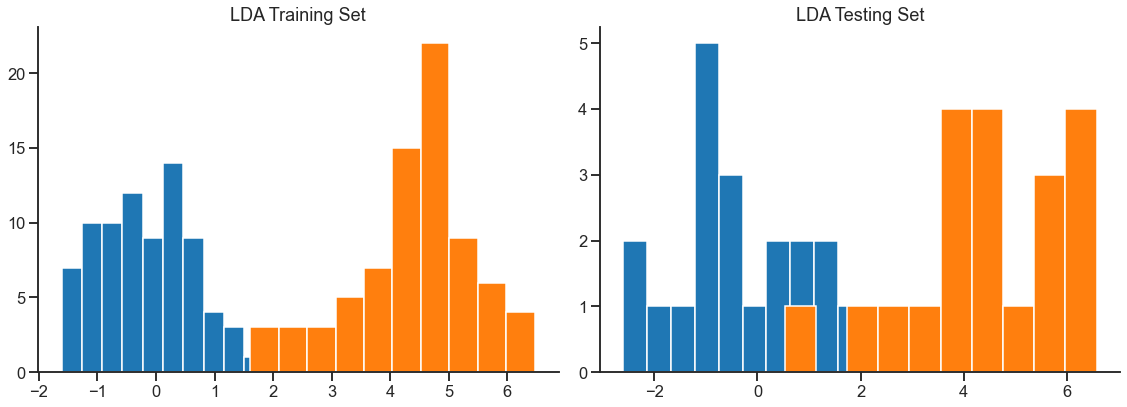

Cross valid Accuracy: 0.93 (+/- 0.16)




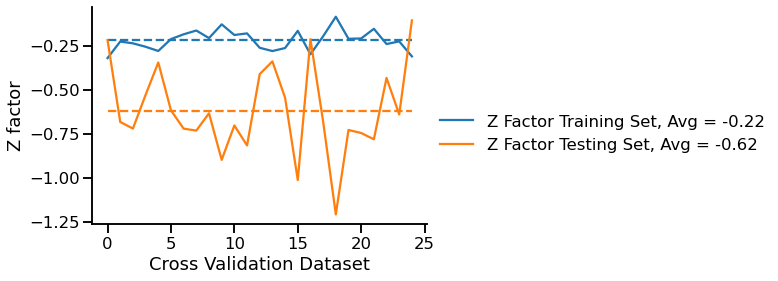

In [16]:
output_path_all = output_path+'/lda_all_features/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

train_set_proportion = 0.8
shrink = 'auto'

le = LabelEncoder() 
Y = le.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)
lda_analysis.fit(x_train, y_train)

LDA_train = lda_analysis.transform(x_train)
LDA_test = lda_analysis.transform(x_test)

df_training_set = pd.DataFrame()

with sns.axes_style("white"), sns.axes_style("ticks"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(LDA_train[y_train==0], label=ctrl_neg)
	axes[0].hist(LDA_train[y_train==1], label=ctrl_pos)
	axes[0].set_title('LDA Training Set')
	axes[1].hist(LDA_test[y_test==0], label=ctrl_neg)
	axes[1].hist(LDA_test[y_test==1], label=ctrl_pos)
	axes[1].set_title('LDA Testing Set')
	plt.tight_layout()
	sns.despine()
	plt.savefig(output_path_all+'LDA_training_test_set_shrinkage_'+str(shrink)+'_all_set.pdf', bbox_inches='tight')
	plt.show()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda_analysis, X, Y, cv=10)
print("Cross valid Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print('\n')

list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X, Y, 25, train_set_proportion)

xpoints = range(len(list_z_test))

training = ['Training'] * len(list_z_train)
testing = ['Testing'] * len(list_z_test)

training_df = pd.DataFrame(
    {'Y': list_z_train,
     'X': xpoints,
     'Hue': training
    })

testing_df = pd.DataFrame(
    {'Y': list_z_test,
     'X': xpoints,
     'Hue': testing
    })

test_train = training_df.append(testing_df).reset_index(drop=True)

sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Cross Validation Dataset', ylabel='Z factor')
plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors=sns.color_palette()[0], linestyles='dashed')
plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors=sns.color_palette()[1], linestyles='dashed')
sns.despine()
# Put the legend out of the figure and remove title
handles, labels = ax.get_legend_handles_labels()
ax.legend(['Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train), 
           'Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test)], handles=handles[2:], labels=labels[2:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_all+'LDA_CV_ZFactor.pdf', bbox_inches='tight')

### Correlations: Feature Correlations

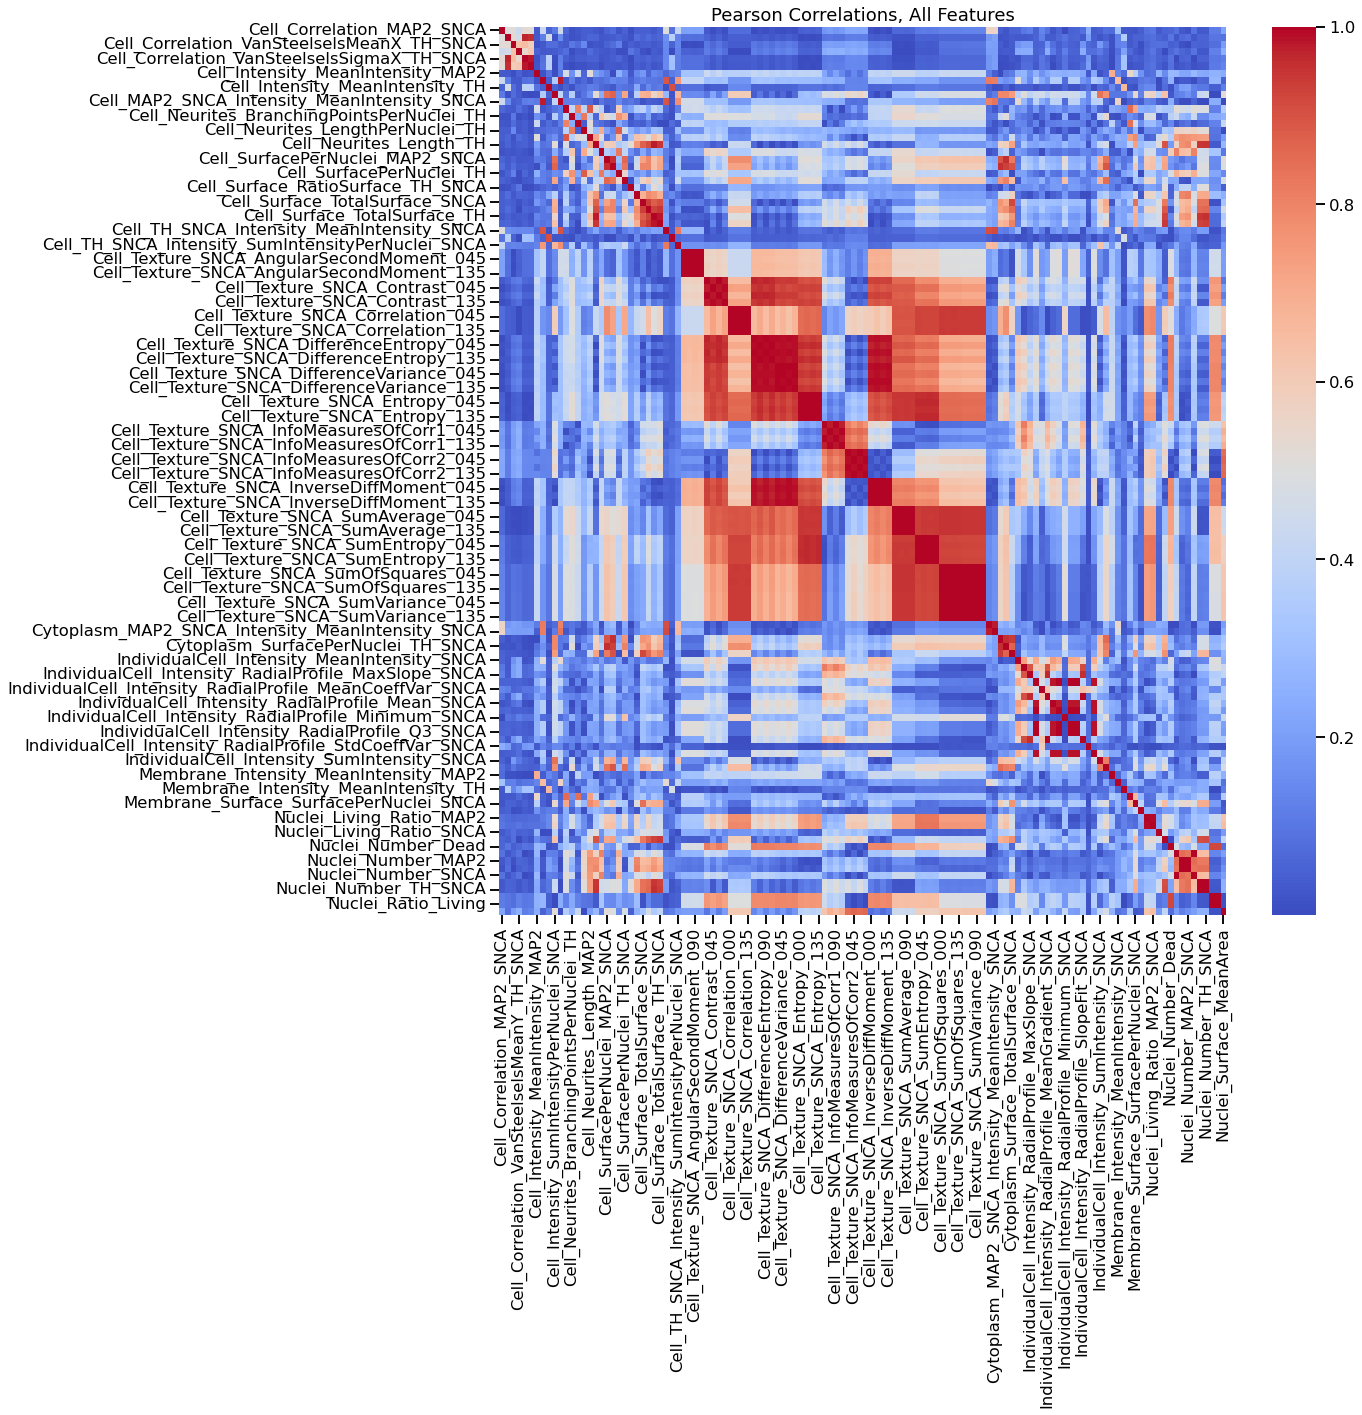

In [17]:
output_path_corr = output_path+'/Pearson_Correlations/'

if not os.path.exists(output_path_corr):
	os.makedirs(output_path_corr, exist_ok=True)

correlations = X.corr().abs()

sns.set_context("talk", font_scale=1)
f, ax = plt.subplots(figsize=(20, 20))
h = sns.heatmap(correlations, cmap='coolwarm')
plt.title('Pearson Correlations, All Features')
plt.tight_layout()
plt.savefig(output_path_corr+"pearson_correlations_all_features.pdf", bbox_inches='tight')
plt.show()

### Loop through correlation thresholds

The goal is to identify the correlation threshold yielding the highest Z factor between the two reference classes as determined by LDA.

In [18]:
def apply_threhold_correlations(X, thr):
    corr_between_features = thr
    new_correlations = X.corr().abs()

    upper = new_correlations.where(np.triu(np.ones(new_correlations.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_between_features)]

    # print('Dropped Features :')
    # display(to_drop)
    print('New Feature Size = ', len(X.columns)-len(to_drop))

    df_X_without_correlated = X.copy()
    df_X_without_correlated.drop(to_drop, axis=1, inplace=True)

    return df_X_without_correlated

def classif_lda(X, Y, train_set_proportion = 0.8, shrink = 'auto'):

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

    lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)

    # print(x_train.columns)

    lda_analysis.fit(x_train, y_train)

    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(lda_analysis, X, Y, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

    list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X, Y, 25, train_set_proportion)

    return scores.mean(), list_z_train, list_z_test

### Plotting of correlation thresholds vs Z Factor and CV Accuracy

New Feature Size =  2
New Feature Size =  2
New Feature Size =  2
New Feature Size =  2
New Feature Size =  2
New Feature Size =  2
New Feature Size =  4
New Feature Size =  6
New Feature Size =  10
New Feature Size =  14
New Feature Size =  16
New Feature Size =  20
New Feature Size =  23
New Feature Size =  26
New Feature Size =  28
New Feature Size =  39
New Feature Size =  49
New Feature Size =  57
Accuracy: 0.61 (+/- 0.18)
Accuracy: 0.61 (+/- 0.18)
Accuracy: 0.61 (+/- 0.18)
Accuracy: 0.61 (+/- 0.18)
Accuracy: 0.61 (+/- 0.18)
Accuracy: 0.61 (+/- 0.18)
Accuracy: 0.76 (+/- 0.19)
Accuracy: 0.85 (+/- 0.21)
Accuracy: 0.86 (+/- 0.21)
Accuracy: 0.85 (+/- 0.21)
Accuracy: 0.86 (+/- 0.21)
Accuracy: 0.86 (+/- 0.20)
Accuracy: 0.86 (+/- 0.19)
Accuracy: 0.92 (+/- 0.15)
Accuracy: 0.92 (+/- 0.16)
Accuracy: 0.93 (+/- 0.15)
Accuracy: 0.92 (+/- 0.15)
Accuracy: 0.93 (+/- 0.15)


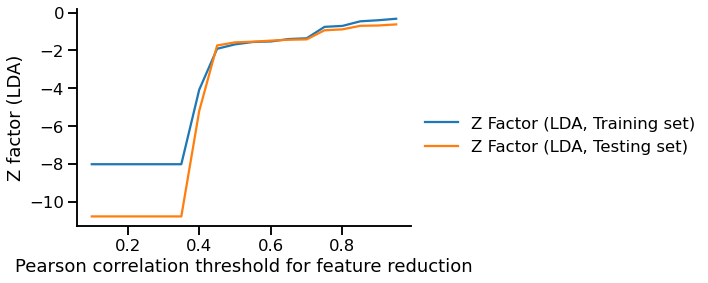

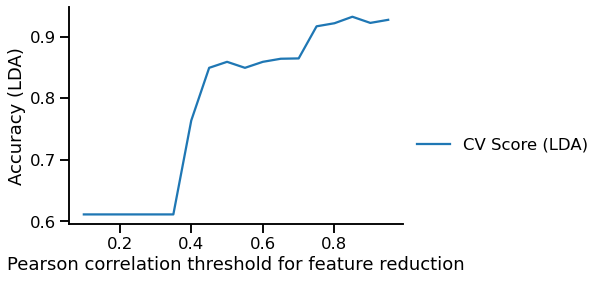

Threshold maximizing LDA Z Factor Test:  0.9500000000000003


In [19]:
list_df_thr_correlations = []
list_thr = []

for thr in np.arange(0.1, 1.0, 0.05):
    list_df_thr_correlations.append(apply_threhold_correlations(X, thr))
    list_thr.append(thr)

list_scores = []
list_avg_z_train = []
list_avg_z_test = []

for df_data in list_df_thr_correlations:
    scores, z_train, z_test = classif_lda(df_data, Y, train_set_proportion = 0.8, shrink = 'auto')
    list_scores.append(scores)
    list_avg_z_train.append(np.mean(z_train))
    list_avg_z_test.append(np.mean(z_test))

# Generating dataframe for plotting
training = ['Z Factor (LDA, Training set)'] * len(list_avg_z_train)
testing = ['Z Factor (LDA, Testing set)'] * len(list_avg_z_test)
LDA_CV_score = ['CV Score (LDA)'] * len(list_scores)

df_list_scores = pd.DataFrame(
    {'Y': list_scores,
     'X': list_thr,
     'Hue': LDA_CV_score
    })

df_avg_z_train = pd.DataFrame(
    {'Y': list_avg_z_train,
     'X': list_thr,
     'Hue': training
    })

df_avg_z_test = pd.DataFrame(
    {'Y': list_avg_z_test,
     'X': list_thr,
     'Hue': testing
    })

test_train = df_avg_z_train.append(df_avg_z_test).reset_index(drop=True)

# Plotting
sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Pearson correlation threshold for feature reduction', ylabel='Z factor (LDA)')
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_corr+"lda_zfactor_function_correlation_thr.pdf", bbox_inches='tight')
plt.show()

ax1 = sns.lineplot(data=df_list_scores, x='X', y='Y', hue='Hue')
ax1.set(xlabel='Pearson correlation threshold for feature reduction', ylabel='Accuracy (LDA)')
sns.despine()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[0:], labels=labels[0:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_corr+"lda_CVscore_function_correlation_thr.pdf", bbox_inches='tight')
plt.show()

threshold_validated = list_thr[np.argmax(list_avg_z_test)]

print('Threshold maximizing LDA Z Factor Test: ', threshold_validated)

### Remove Correlated Features above the defined threshold:

Dropped Features :


['Cell_Correlation_VanSteelselsSigmaX_TH_SNCA',
 'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA',
 'Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA',
 'Cell_SurfacePerNuclei_SNCA',
 'Cell_Surface_TotalSurface_TH',
 'Cell_Surface_TotalSurface_TH_SNCA',
 'Cell_Texture_SNCA_AngularSecondMoment_045',
 'Cell_Texture_SNCA_AngularSecondMoment_090',
 'Cell_Texture_SNCA_AngularSecondMoment_135',
 'Cell_Texture_SNCA_Contrast_045',
 'Cell_Texture_SNCA_Contrast_090',
 'Cell_Texture_SNCA_Contrast_135',
 'Cell_Texture_SNCA_Correlation_045',
 'Cell_Texture_SNCA_Correlation_090',
 'Cell_Texture_SNCA_Correlation_135',
 'Cell_Texture_SNCA_DifferenceEntropy_000',
 'Cell_Texture_SNCA_DifferenceEntropy_045',
 'Cell_Texture_SNCA_DifferenceEntropy_090',
 'Cell_Texture_SNCA_DifferenceEntropy_135',
 'Cell_Texture_SNCA_DifferenceVariance_000',
 'Cell_Texture_SNCA_DifferenceVariance_045',
 'Cell_Texture_SNCA_DifferenceVariance_090',
 'Cell_Texture_SNCA_DifferenceVariance_135',
 'Cell_Texture_SNCA_Entropy_000',
 'Cell_

67

Index(['Cell_Correlation_MAP2_SNCA', 'Cell_Correlation_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanX_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanY_TH_SNCA',
       'Cell_Intensity_MeanIntensity_MAP2',
       'Cell_Intensity_MeanIntensity_SNCA', 'Cell_Intensity_MeanIntensity_TH',
       'Cell_Intensity_SumIntensityPerNuclei_SNCA',
       'Cell_Neurites_BranchingPointsPerNuclei_MAP2',
       'Cell_Neurites_BranchingPointsPerNuclei_TH',
       'Cell_Neurites_LengthPerNuclei_MAP2',
       'Cell_Neurites_LengthPerNuclei_TH', 'Cell_Neurites_Length_MAP2',
       'Cell_Neurites_Length_TH', 'Cell_SurfacePerNuclei_MAP2',
       'Cell_SurfacePerNuclei_MAP2_SNCA', 'Cell_SurfacePerNuclei_TH',
       'Cell_SurfacePerNuclei_TH_SNCA', 'Cell_Surface_RatioSurface_TH_SNCA',
       'Cell_Surface_TotalSurface_MAP2', 'Cell_Surface_TotalSurface_SNCA',
       'Cell_Surface_TotalSurface_SNCA_MAP2',
       'Cell_TH_SNCA_Intensity_MeanIntensity_SNCA',
       'Cell_TH_SNCA_Intensity_MeanIntensity_TH

'FinalFeatures : '

57

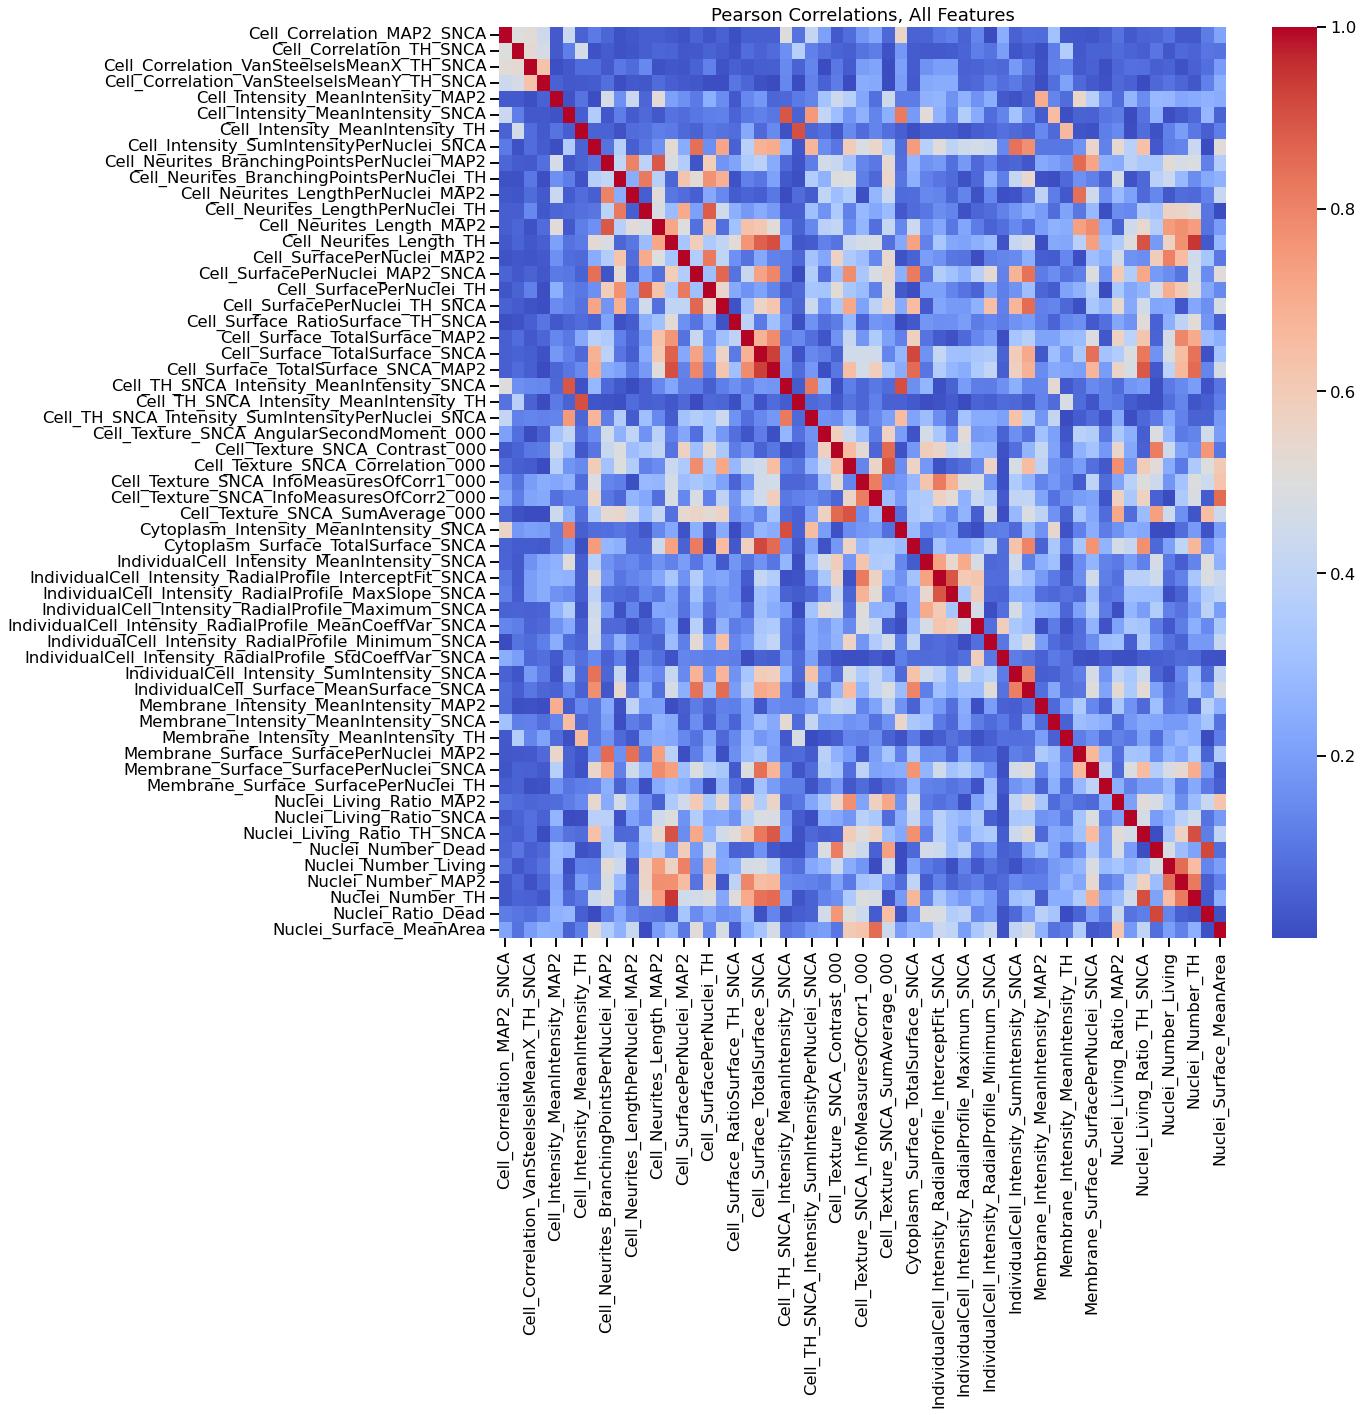

In [20]:
corr_between_features = threshold_validated #correlation threshold between features
new_correlations = X.corr().abs()

upper = new_correlations.where(np.triu(np.ones(new_correlations.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_between_features)]

print('Dropped Features :')
display(to_drop)
display(len(to_drop))

df_X_without_correlated = X.copy()
df_X_without_correlated.drop(to_drop, axis=1, inplace=True)

display(df_X_without_correlated.columns)
display('FinalFeatures : ', len(df_X_without_correlated.columns))

sns.set_context("talk", font_scale=1)
f, ax = plt.subplots(figsize=(20, 20))
h = sns.heatmap(df_X_without_correlated.corr().abs(), cmap='coolwarm')
plt.title('Pearson Correlations, All Features')
plt.tight_layout()
plt.savefig(output_path_corr+"person_correlations_after_selection.pdf", bbox_inches='tight')
plt.show()

### LightGBM Analysis¶

Fit of two previously selected reference classes to identify features which contribute the most to reference class separation.

There are 0 features with 0.0 importance
    index                                            feature  importance  \
0      16                           Cell_SurfacePerNuclei_TH      10.555   
1      47               Membrane_Surface_SurfacePerNuclei_TH       7.575   
2      14                         Cell_SurfacePerNuclei_MAP2       7.035   
3      52                               Nuclei_Number_Living       6.920   
4      18                  Cell_Surface_RatioSurface_TH_SNCA       4.250   
5      48                           Nuclei_Living_Ratio_MAP2       4.080   
6      11                   Cell_Neurites_LengthPerNuclei_TH       2.420   
7      10                 Cell_Neurites_LengthPerNuclei_MAP2       1.700   
8       4                  Cell_Intensity_MeanIntensity_MAP2       1.660   
9      26                     Cell_Texture_SNCA_Contrast_000       1.455   
10     19                     Cell_Surface_TotalSurface_MAP2       1.305   
11     34  IndividualCell_Intensity_RadialProfi

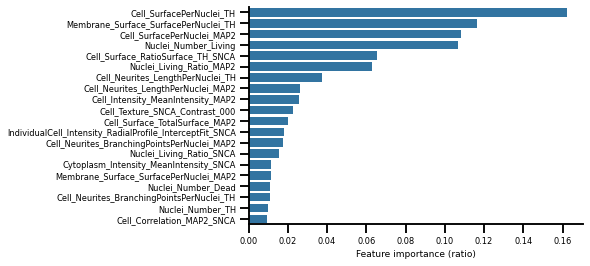

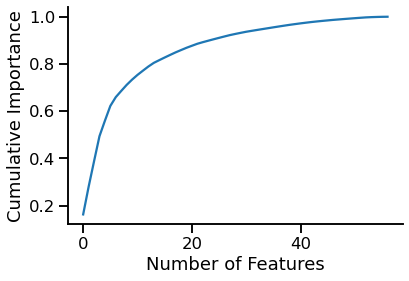

In [21]:
le = LabelEncoder() 
trainY = le.fit_transform(Y)

n=200
feature_importances = np.zeros(df_X_without_correlated.shape[1])
for i in range(n): 
   
    lgb_model = lgb.LGBMClassifier( boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    train_features, valid_features, train_y, valid_y = train_test_split(df_X_without_correlated, trainY, test_size = 0.1, random_state = i)      
    lgb_model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 0)       
    feature_importances += lgb_model.feature_importances_

feature_importances = feature_importances / n
feature_importances = pd.DataFrame({'feature': list(df_X_without_correlated.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

output_path_LGBM = output_path+'/LightGBM_after_correlations/'

if not os.path.exists(output_path_LGBM):
	os.makedirs(output_path_LGBM, exist_ok=True)

# Evaluate number of features without any significnace for LightGBM classification
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index()

# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])

#plt.figure(figsize=(10, 20))
#ax = plt.subplot()

df_feature_importances = pd.DataFrame(
    {'Features': feature_importances['feature'],
     'Importance (fraction)': feature_importances['importance_normalized'],
     'cumulative_importance': feature_importances['cumulative_importance']
    })

feature_importances_head20 = feature_importances.head(20)
print(feature_importances_head20)

sns.set_context("talk", font_scale=0.5)
ax = sns.barplot(x="importance_normalized", y="feature", data=feature_importances_head20, color="#1f77b4")
ax.set(xlabel='Feature importance (ratio)', ylabel='')
sns.despine()
plt.savefig(output_path_LGBM+"LightGBM_FeatureContributions_after_PearsonThreshold.pdf", bbox_inches='tight')
plt.show()

# Cumulative importance plot
feature_importances['position'] = list(range(len(feature_importances)))
sns.set_context("talk")
ax1 = sns.lineplot(data=feature_importances, x='position', y='cumulative_importance')
ax1.set(xlabel='Number of Features', ylabel='Cumulative Importance')
sns.despine()
plt.savefig(output_path_LGBM+"LightGBM_CumulativeImportance.pdf", bbox_inches='tight')
plt.show()

### Select number of features for LDA based on LightGBM classifier
Pick the number of features that will be used for the subsequent LDA. You can choose all features or select only the contributing ones as determined above. EXAMPLE: If total number of features is 105 and 12 are not contributing, select 93 features for LDA.

In [22]:
n_feat = len(feature_importances['feature'])

nb_feat_select = n_feat - 0

display(nb_feat_select)

57

### LDA Analysis (with feature selection by previous Pearson Correlations Threshold)

0                              Cell_SurfacePerNuclei_TH
1                  Membrane_Surface_SurfacePerNuclei_TH
2                            Cell_SurfacePerNuclei_MAP2
3                                  Nuclei_Number_Living
4                     Cell_Surface_RatioSurface_TH_SNCA
5                              Nuclei_Living_Ratio_MAP2
6                      Cell_Neurites_LengthPerNuclei_TH
7                    Cell_Neurites_LengthPerNuclei_MAP2
8                     Cell_Intensity_MeanIntensity_MAP2
9                        Cell_Texture_SNCA_Contrast_000
10                       Cell_Surface_TotalSurface_MAP2
11    IndividualCell_Intensity_RadialProfile_Interce...
12          Cell_Neurites_BranchingPointsPerNuclei_MAP2
13                             Nuclei_Living_Ratio_SNCA
14               Cytoplasm_Intensity_MeanIntensity_SNCA
15               Membrane_Surface_SurfacePerNuclei_MAP2
16                                   Nuclei_Number_Dead
17            Cell_Neurites_BranchingPointsPerNu

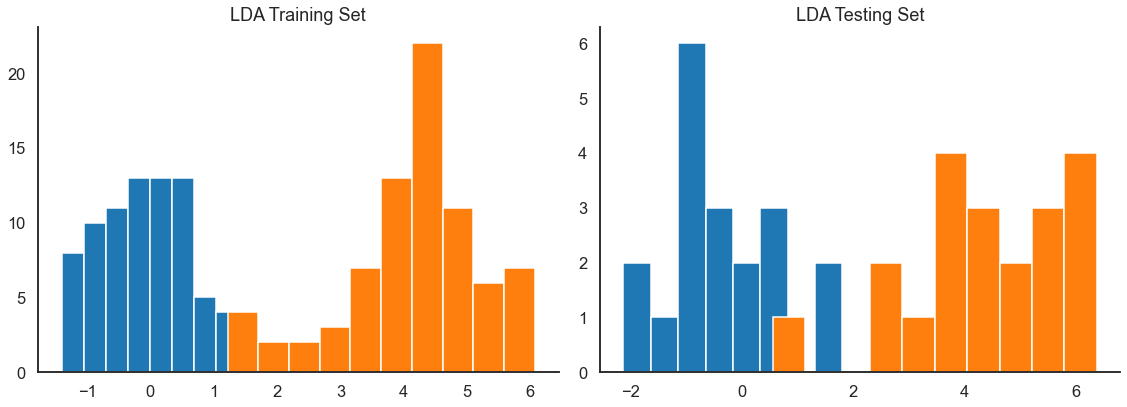

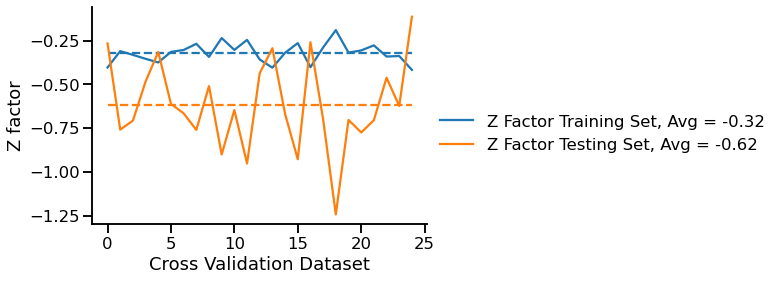

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LRRK2 WT: DoD 50 v.s. LRRK2 Mut: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=8.358e-01 U_stat=1.931e+03
SNCA WT: DoD 50 v.s. SNCA triplication: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=1.347e-32 U_stat=2.507e+03
LRRK2 WT: DoD 37 v.s. LRRK2 WT: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=3.199e-18 U_stat=3.544e+03
LRRK2 Mut: DoD 37 v.s. LRRK2 Mut: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=8.168e-01 U_stat=5.145e+03
SNCA WT: DoD 37 v.s. SNCA WT: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=1.109e-41 U_stat=1.550e+04
SNCA triplication: DoD 37 v.s. SNCA triplication: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=8.121e-32 U_stat=1.534e+04


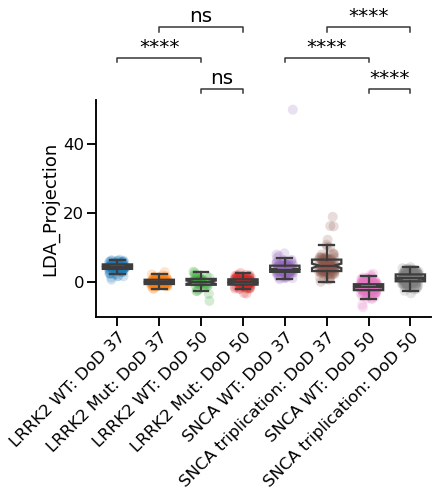

In [23]:
output_path_all = output_path+'/LDA_features_after_correlations/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

train_set_proportion = 0.8
shrink = 'auto'

subset_columns = (feature_importances['feature'])[0:nb_feat_select]
print(subset_columns)

X_subset = df_X_without_correlated[subset_columns]

x_train, x_test, y_train, y_test = train_test_split(X_subset, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)

print(x_train.columns)

lda_analysis.fit(x_train, y_train)

LDA_train = lda_analysis.transform(x_train)
LDA_test = lda_analysis.transform(x_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda_analysis, X_subset, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


with sns.axes_style("white"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(LDA_train[y_train==0], label=ctrl_neg)
	axes[0].hist(LDA_train[y_train==1], label=ctrl_pos)
	axes[0].set_title('LDA Training Set')
	axes[1].hist(LDA_test[y_test==0], label=ctrl_neg)
	axes[1].hist(LDA_test[y_test==1], label=ctrl_pos)
	axes[1].set_title('LDA Testing Set')
	plt.tight_layout()
	sns.despine()
	plt.savefig(output_path_all+'LDA_training_test_set_shrinkage_'+str(shrink)+'_after_correlations.pdf', bbox_inches='tight')
	plt.show()

X_all_cpds_subset = X_all_cpds[subset_columns]

LDA_dmso_and_cpds_subset = lda_analysis.transform(X_all_cpds_subset)

X_all_cpds_subset_lda = X_all_cpds_subset.copy()

X_all_cpds_subset_lda['LDA_Projection'] = LDA_dmso_and_cpds_subset[:,0]
X_all_cpds_subset_lda['tags'] = Y_all_cpds

list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X_subset, Y, 25, train_set_proportion)

xpoints = range(len(list_z_test))

training = ['Training'] * len(list_z_train)
testing = ['Testing'] * len(list_z_test)

training_df = pd.DataFrame(
    {'Y': list_z_train,
     'X': xpoints,
     'Hue': training
    })

testing_df = pd.DataFrame(
    {'Y': list_z_test,
     'X': xpoints,
     'Hue': testing
    })

test_train = training_df.append(testing_df).reset_index(drop=True)

sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Cross Validation Dataset', ylabel='Z factor')
plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors=sns.color_palette()[0], linestyles='dashed')
plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors=sns.color_palette()[1], linestyles='dashed')
sns.despine()
# Put the legend out of the figure and remove title
handles, labels = ax.get_legend_handles_labels()
ax.legend(['Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train), 
           'Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test)], handles=handles[2:], labels=labels[2:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_all+"LDA_Cross_Validation_Dataset"+str(shrink)+"_after_correlations.pdf", bbox_inches='tight')
plt.show()

# Plotting
sns.set_context("talk")
ax = sns.boxplot(x='tags', y='LDA_Projection', data=X_all_cpds_subset_lda, width=0.7, showfliers=False, zorder=1,
                 order=order, notch=1, bootstrap = 1000)
# Transparancy of boxplot filling color
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
s = sns.stripplot(x='tags', y='LDA_Projection', data=X_all_cpds_subset_lda, order=order, size=10, alpha=0.2, jitter=0.2, 
                  zorder=0)
from statannot import add_stat_annotation
# Stat annotations
add_stat_annotation(s, data=X_all_cpds_subset_lda, x='tags', y='LDA_Projection', box_pairs=box_pairs,
               loc='outside', verbose=1, test='Mann-Whitney', comparisons_correction=None,
               perform_stat_test=True, order=order,
               color='0.2', linewidth=1.5,
               fontsize=20)
s.set(xlabel=None)
s.set_xticklabels(s.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")
sns.despine()
plt.savefig(output_path_all+"LDA_Projection_All_Conditions_after_correlations_shrinkage_"+str(shrink)+".pdf", bbox_inches='tight')
plt.show()

### SVM Analysis (with feature selection by previous Pearson Correlations Threshold)
Selection of hyperparameters by SciKitLearn's grid search using cross validation.

In [24]:
train_set_proportion = 0.8

x_train_grid, x_test_grid, y_train_grid, y_test_grid = train_test_split(df_X_without_correlated[subset_columns], Y, train_size=train_set_proportion, stratify=Y, random_state=100)

# Set the parameters by cross-validation

tested_C = list(np.linspace(0.05, 1., 20))
tested_C.append(1.5)
tested_C.append(2)
tested_C.append(3)
tested_C.append(5)
tested_C.append(10)

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": ['scale'], "C": tested_C}, # np.logspace(-2, 1, 100)
    {"kernel": ["poly"], "gamma": ['scale'], "C": tested_C},
    {"kernel": ["linear"], "C": tested_C},
]

best_C = []

clf = SVC()

for parameters in tuned_parameters:
    
    cv = GridSearchCV(clf, param_grid=parameters, scoring="f1", 
                      cv=StratifiedShuffleSplit(n_splits=4, test_size=1.-train_set_proportion, random_state=0))
    cv.fit(df_X_without_correlated[subset_columns], Y)
    C = cv.best_estimator_
    best_C.append(C)

    print(parameters)
    print(C)

print()
print('GridSearchCV Optimized for rbf kernel :')
print("\'kernel\': [\'rbf\'], \'gamma\': [\'scale\'], \'C\': [",best_C[0].C,"]")
print()

{'kernel': ['rbf'], 'gamma': ['scale'], 'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0, 1.5, 2, 3, 5, 10]}
SVC(C=3)
{'kernel': ['poly'], 'gamma': ['scale'], 'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0, 1.5, 2, 3, 5, 10]}
SVC(C=10, kernel='poly')
{'kernel': ['linear'], 'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0, 1.5, 2, 3, 5, 10]}
SVC(C=0.1, kernel='linear')

GridSearchCV Optimized for rbf kernel :
'kernel': ['rbf'], 'gamma': ['scale'], 'C': [ 3 ]



### SVM classifier with tuned hyperparameters

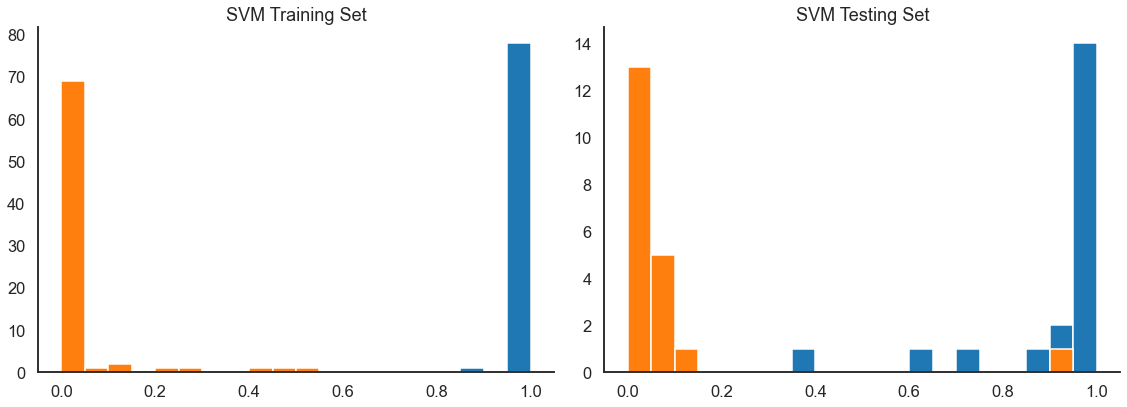

Cross Valid Accuracy: 0.93 (+/- 0.15)


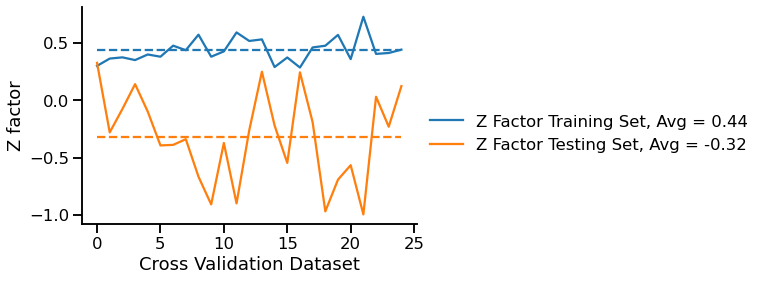

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LRRK2 WT: DoD 50 v.s. LRRK2 Mut: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=3.617e-18 U_stat=6.300e+01
SNCA WT: DoD 50 v.s. SNCA triplication: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=8.445e-21 U_stat=1.904e+04
LRRK2 WT: DoD 37 v.s. LRRK2 WT: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=6.367e-16 U_stat=1.700e+02
LRRK2 Mut: DoD 37 v.s. LRRK2 Mut: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=3.649e-04 U_stat=6.519e+03
SNCA WT: DoD 37 v.s. SNCA WT: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=1.249e-38 U_stat=3.440e+02
SNCA triplication: DoD 37 v.s. SNCA triplication: DoD 50: Mann-Whitney-Wilcoxon test two-sided, P_val=7.317e-21 U_stat=2.561e+03


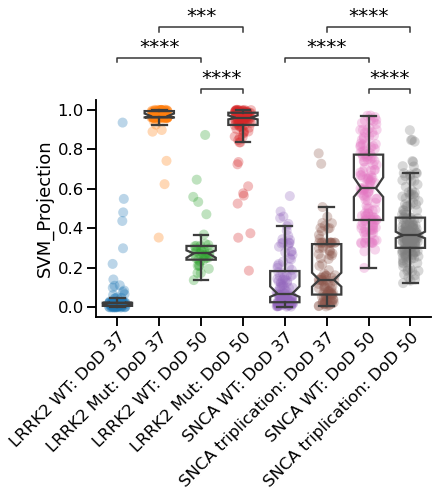

In [25]:
output_path_all = output_path+'/SVM_features_after_correlations/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

C = best_C[0].C # clf.best_params_['C']

svm_analysis = SVC(probability=True, kernel='rbf', C=C, gamma='scale')
svm_analysis.fit(x_train, y_train)

SVM_train = svm_analysis.predict_proba(x_train)
SVM_test = svm_analysis.predict_proba(x_test)

binwidth = 0.05
bins = np.arange(0, 1. + binwidth, binwidth)

with sns.axes_style("white"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(SVM_train[y_train==0,0], label=ctrl_neg, bins=bins)
	axes[0].hist(SVM_train[y_train==1,0], label=ctrl_pos, bins=bins)
	axes[0].set_title('SVM Training Set')
	axes[1].hist(SVM_test[y_test==0,0], label=ctrl_neg, bins=bins)
	axes[1].hist(SVM_test[y_test==1,0], label=ctrl_pos, bins=bins)
	axes[1].set_title('SVM Testing Set')
	plt.tight_layout()
	sns.despine()
	plt.savefig(output_path_all+'SVM_training_test_set_after_correlations.pdf', bbox_inches='tight')
	plt.show()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_analysis, X_subset, Y, cv=10)
print("Cross Valid Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

SVM_dmso_and_cpds = svm_analysis.predict_proba(X_all_cpds_subset)
X_all_cpds_svm = X_all_cpds_subset.copy()

X_all_cpds_svm['SVM_Projection'] = SVM_dmso_and_cpds[:,0]
X_all_cpds_svm['tags'] = Y_all_cpds


list_z_train, list_z_test = cross_valid_z_prime_svm(svm_analysis, X_subset, Y, 25, train_set_proportion, output_path_all)

xpoints = range(len(list_z_test))

training = ['Training'] * len(list_z_train)
testing = ['Testing'] * len(list_z_test)

training_df = pd.DataFrame(
    {'Y': list_z_train,
     'X': xpoints,
     'Hue': training
    })

testing_df = pd.DataFrame(
    {'Y': list_z_test,
     'X': xpoints,
     'Hue': testing
    })

test_train = training_df.append(testing_df).reset_index(drop=True)

sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Cross Validation Dataset', ylabel='Z factor')
plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors=sns.color_palette()[0], linestyles='dashed')
plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors=sns.color_palette()[1], linestyles='dashed')
sns.despine()
# Put the legend out of the figure and remove title
handles, labels = ax.get_legend_handles_labels()
ax.legend(['Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train), 
           'Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test)], handles=handles[2:], labels=labels[2:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_all+'SVM_CV_ZFactor_after_correlations.pdf', bbox_inches='tight')
plt.show()

X_all_cpds_pl_well = X_all_cpds_subset.reset_index()
plates = X_all_cpds_pl_well['Plate']

list_tags_plates = []
for i in range(len(Y_all_cpds)):
    list_tags_plates.append(Y_all_cpds[i]+'_'+plates[i])
    
X_all_cpds_svm['tags_plate'] = list_tags_plates

sns.set_context("talk")

ax = sns.boxplot(x='tags', y='SVM_Projection', data=X_all_cpds_svm, width=0.7, showfliers=False, zorder=1,
                 order=order, notch=1, bootstrap = 1000)
# Transparancy of boxplot filling color
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
s = sns.stripplot(x='tags', y='SVM_Projection', data=X_all_cpds_svm, order=order, size=10, alpha=0.3, jitter=0.2, zorder=0)
from statannot import add_stat_annotation

add_stat_annotation(s, data=X_all_cpds_svm, x='tags', y='SVM_Projection', box_pairs=box_pairs,
               loc='outside', verbose=1, test='Mann-Whitney', comparisons_correction=None,
               perform_stat_test=True, order=order,
               color='0.2', linewidth=1.5,
               fontsize=20)
s.set(xlabel=None)
s.set_xticklabels(s.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")
sns.despine()
plt.savefig(output_path_all+"SVM_Projection_All_Conditions_after_correlations.pdf", bbox_inches='tight')
plt.show()

### Function to calculate Z Factor:

In [26]:
def get_acc_zfactor(lda_analysis, x_train, y_train, x_test, y_test):

    lda_analysis.fit(x_train, y_train)
    
    accuracy_train = lda_analysis.score(x_train, y_train)
    accuracy_test = lda_analysis.score(x_test, y_test)

    x_neg_train = lda_analysis.transform(x_train[y_train == 0])
    x_pos_train = lda_analysis.transform(x_train[y_train == 1])

    z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
        np.mean(x_neg_train) - np.mean(x_pos_train))

    x_neg_test = lda_analysis.transform(x_test[y_test == 0])
    x_pos_test = lda_analysis.transform(x_test[y_test == 1])

    z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

    return accuracy_train, accuracy_test, z_train, z_test

def get_acc_zfactor_svm(svm_analysis, x_train, y_train, x_test, y_test):

    svm_analysis.fit(x_train, y_train)
    
    accuracy_train = svm_analysis.score(x_train, y_train)
    accuracy_test = svm_analysis.score(x_test, y_test)

    x_neg_train = svm_analysis.predict_proba(x_train[y_train == 0])[:,0]
    x_pos_train = svm_analysis.predict_proba(x_train[y_train == 1])[:,0]

    z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
        np.mean(x_neg_train) - np.mean(x_pos_train))

    x_neg_test = svm_analysis.predict_proba(x_test[y_test == 0])[:,0]
    x_pos_test = svm_analysis.predict_proba(x_test[y_test == 1])[:,0]

    z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

    # print(z_train, z_test)

    return accuracy_train, accuracy_test, z_train, z_test

### LOO Features (LDA & SVM):

In [27]:
def LOO_features_LDA(X, Y, train_set_proportion = 0.8, shrink = 'auto', seed=100):

    lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=seed)

    accuracy_train, accuracy_test, z_train, z_test = get_acc_zfactor(lda_analysis, x_train, y_train, x_test, y_test)

    list_feature_removed = []
    list_acc_train = []
    list_acc_test = []
    list_z_train = []
    list_z_test = []

    for f in x_train.columns:

        x_train_loo = x_train.drop([f], axis=1)
        x_test_loo = x_test.drop([f], axis=1)

        accuracy_train_loo, accuracy_test_loo, z_train_loo, z_test_loo = get_acc_zfactor(lda_analysis, x_train_loo, y_train, x_test_loo, y_test)

        list_feature_removed.append(f)
        list_acc_train.append(accuracy_train_loo)
        list_acc_test.append(accuracy_test_loo)
        list_z_train.append(z_train_loo)
        list_z_test.append(z_test_loo)
    
    return accuracy_train, accuracy_test, z_train, z_test, list_feature_removed, list_acc_train, list_acc_test, list_z_train, list_z_test

def LOO_features_SVM(X, Y, train_set_proportion, C, seed=100):

    svm_analysis = SVC(probability=True, kernel='rbf', C=C, gamma='scale')
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=seed)

    accuracy_train, accuracy_test, z_train, z_test = get_acc_zfactor_svm(svm_analysis, x_train, y_train, x_test, y_test)

    list_feature_removed = []
    list_acc_train = []
    list_acc_test = []
    list_z_train = []
    list_z_test = []

    for f in x_train.columns:

        x_train_loo = x_train.drop([f], axis=1)
        x_test_loo = x_test.drop([f], axis=1)

        accuracy_train_loo, accuracy_test_loo, z_train_loo, z_test_loo = get_acc_zfactor_svm(svm_analysis, x_train_loo, y_train, x_test_loo, y_test)

        list_feature_removed.append(f)
        list_acc_train.append(accuracy_train_loo)
        list_acc_test.append(accuracy_test_loo)
        list_z_train.append(z_train_loo)
        list_z_test.append(z_test_loo)
    
    return accuracy_train, accuracy_test, z_train, z_test, list_feature_removed, list_acc_train, list_acc_test, list_z_train, list_z_test

### Leave One Out based on ZFactor, LDA

Computes the ZFactor shift removing one feature to the SVM classification.

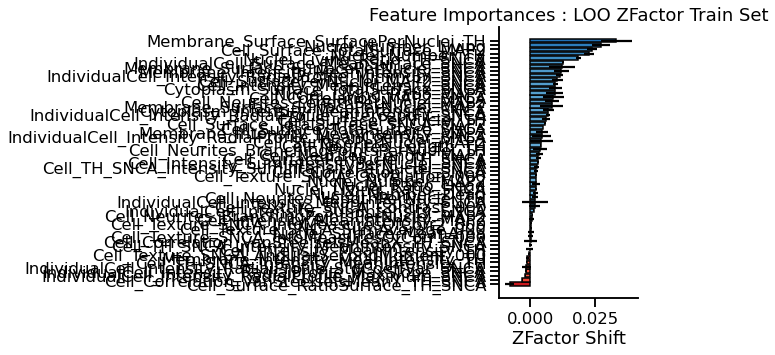

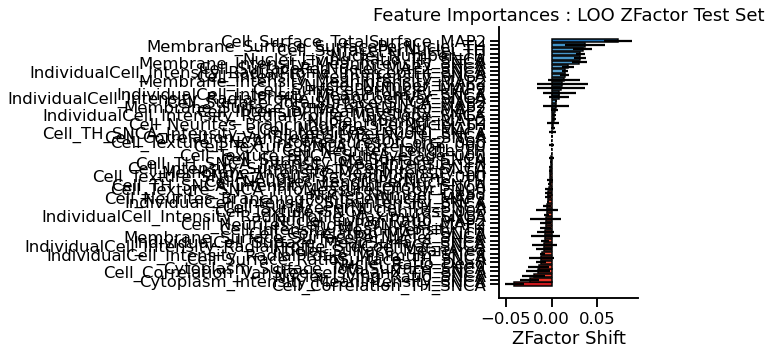

In [28]:
output_path_loo = output_path+'/LOO_Results/'

if not os.path.exists(output_path_loo):
	os.makedirs(output_path_loo, exist_ok=True)

XLOO = X_subset.copy()

CV = 3

lacc_train, lacc_test, lztrain, lztest, llfeature_removed, llacc_train, llacc_test, llz_train, llz_test = [], [], [], [], [], [], [], [], []

for crossval in range(CV):
        acc_train, acc_test, ztrain, ztest, lfeature_removed, lacc_train, lacc_test, lz_train, lz_test = LOO_features_LDA(XLOO, Y, train_set_proportion = 0.8, shrink = 'auto', seed=crossval)
        lacc_train.append(acc_train)
        lacc_test.append(acc_test)
        lztrain.append(ztrain)
        lztest.append(ztest)
        llfeature_removed.append(lfeature_removed)
        llacc_train.append(lacc_train)
        llacc_test.append(lacc_test)
        llz_train.append(lz_train)
        llz_test.append(lz_test)


vec_cv_ztrain = []
vec_cv_ztest = []


for i, val in enumerate(lztrain):
        vec_cv_ztrain.append(-np.array(llz_train[i]) + lztrain[i])
        vec_cv_ztest.append(-np.array(llz_test[i]) + lztest[i])

df_loo_lda = pd.DataFrame()

# display(vec_cv_ztrain)

df_loo_lda['Feature'] = lfeature_removed
df_loo_lda['Diff_ZTrain'] = np.mean(vec_cv_ztrain, axis=0)
df_loo_lda['Diff_ZTest'] = np.mean(vec_cv_ztest, axis=0)
df_loo_lda['std_ZTrain'] = np.std(vec_cv_ztrain, axis=0)
df_loo_lda['std_ZTest'] = np.std(vec_cv_ztest, axis=0)

# display(df_loo_lda['Diff_ZTrain'])
# display(df_loo_lda['std_ZTrain'])

df_loo_lda.sort_values(['Diff_ZTrain'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_lda['Diff_ZTrain']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTrain'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTrain'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

ax.barh(range(len(df_loo_lda)),
        df_loo_lda['Diff_ZTrain'],
        align='center', edgecolor='k', xerr=df_loo_lda['std_ZTrain'], color=my_colors)

ax.set_yticks(range(len(df_loo_lda)))
ax.set_yticklabels(df_loo_lda['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift');
plt.title('Feature Importances : LOO ZFactor Train Set')
plt.savefig(output_path_loo+"LOO_LDA_Train_Set.pdf", bbox_inches='tight')
plt.show()

df_loo_lda.sort_values(['Diff_ZTest'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_lda['Diff_ZTest']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTest'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTest'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

ax.barh(range(len(df_loo_lda)),
        df_loo_lda['Diff_ZTest'],
        align='center', edgecolor='k', xerr=df_loo_lda['std_ZTest'], color=my_colors)

ax.set_yticks(range(len(df_loo_lda)))
ax.set_yticklabels(df_loo_lda['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift');
plt.title('Feature Importances : LOO ZFactor Test Set')
plt.savefig(output_path_loo+"LOO_LDA_Test_Set.pdf", bbox_inches='tight')
plt.show()

### Leave One Out based on ZFactor, SVM
Computes the ZFactor shift removing one feature to the SVM classification.

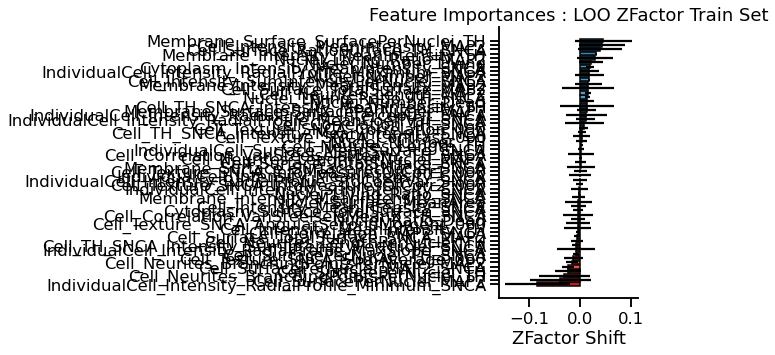

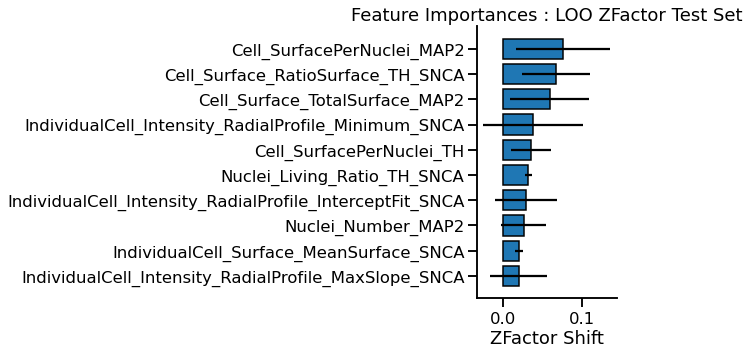

In [29]:
XLOO = X_subset.copy()
C = best_C[0].C

CV = 3

lacc_train, lacc_test, lztrain, lztest, llfeature_removed, llacc_train, llacc_test, llz_train, llz_test = [], [], [], [], [], [], [], [], []

for crossval in range(CV):
        acc_train, acc_test, ztrain, ztest, lfeature_removed, lacc_train, lacc_test, lz_train, lz_test = LOO_features_SVM(XLOO, Y, train_set_proportion = 0.8, C=C, seed=crossval)
        lacc_train.append(acc_train)
        lacc_test.append(acc_test)
        lztrain.append(ztrain)
        lztest.append(ztest)
        llfeature_removed.append(lfeature_removed)
        llacc_train.append(lacc_train)
        llacc_test.append(lacc_test)
        llz_train.append(lz_train)
        llz_test.append(lz_test)


vec_cv_ztrain = []
vec_cv_ztest = []


for i, val in enumerate(lztrain):
        vec_cv_ztrain.append(-np.array(llz_train[i]) + lztrain[i])
        vec_cv_ztest.append(-np.array(llz_test[i]) + lztest[i])

df_loo_svm = pd.DataFrame()

# display(vec_cv_ztrain)

df_loo_svm['Feature'] = lfeature_removed
df_loo_svm['Diff_ZTrain'] = np.mean(vec_cv_ztrain, axis=0)
df_loo_svm['Diff_ZTest'] = np.mean(vec_cv_ztest, axis=0)
df_loo_svm['std_ZTrain'] = np.std(vec_cv_ztrain, axis=0)
df_loo_svm['std_ZTest'] = np.std(vec_cv_ztest, axis=0)

df_loo_svm.sort_values(['Diff_ZTrain'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_svm['Diff_ZTrain']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTrain'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTrain'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

ax.barh(range(len(df_loo_svm)),
        df_loo_svm['Diff_ZTrain'],
        xerr=df_loo_svm['std_ZTest'],
        align='center', edgecolor='k', color=my_colors)

ax.set_yticks(range(len(df_loo_svm)))
ax.set_yticklabels(df_loo_svm['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift')
plt.title('Feature Importances : LOO ZFactor Train Set')
plt.savefig(output_path_loo+"LOO_SVM_Train_Set.pdf", bbox_inches='tight')
plt.show()

df_loo_svm.sort_values(['Diff_ZTest'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_svm['Diff_ZTest']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTest'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTest'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

df_loo_svm = df_loo_svm.sort_values('Diff_ZTest')

df_loo_svm = df_loo_svm.tail(10)

ax.barh(range(len(df_loo_svm)),
        df_loo_svm['Diff_ZTest'],
        xerr=df_loo_svm['std_ZTest'],
        align='center', edgecolor='k', color='#1f77b4')

ax.set_yticks(range(len(df_loo_svm)))
ax.set_yticklabels(df_loo_svm['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift')
plt.title('Feature Importances : LOO ZFactor Test Set')
plt.savefig(output_path_loo+"LOO_SVM_Test_Set.pdf", bbox_inches='tight')
plt.show()